<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/LC_10_15_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 12.9 MB/s eta 0:00:00

LOADING AND PREPROCESSING LENDING CLUB DATASET (GENERIC CSV)
Dataset shape: (50000, 10)
Target distribution: {0: 45000, 1: 5000}
Default rate: 10.00%
Imbalance ratio: 9.00:1

Categorical columns (5): ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
Numeric columns (4): ['revenue', 'dti_n', 'loan_amnt', 'fico_n']...

Number of processed features: 81
First 10 feature names: ['cat__experience_c_1' 'cat__emp_length

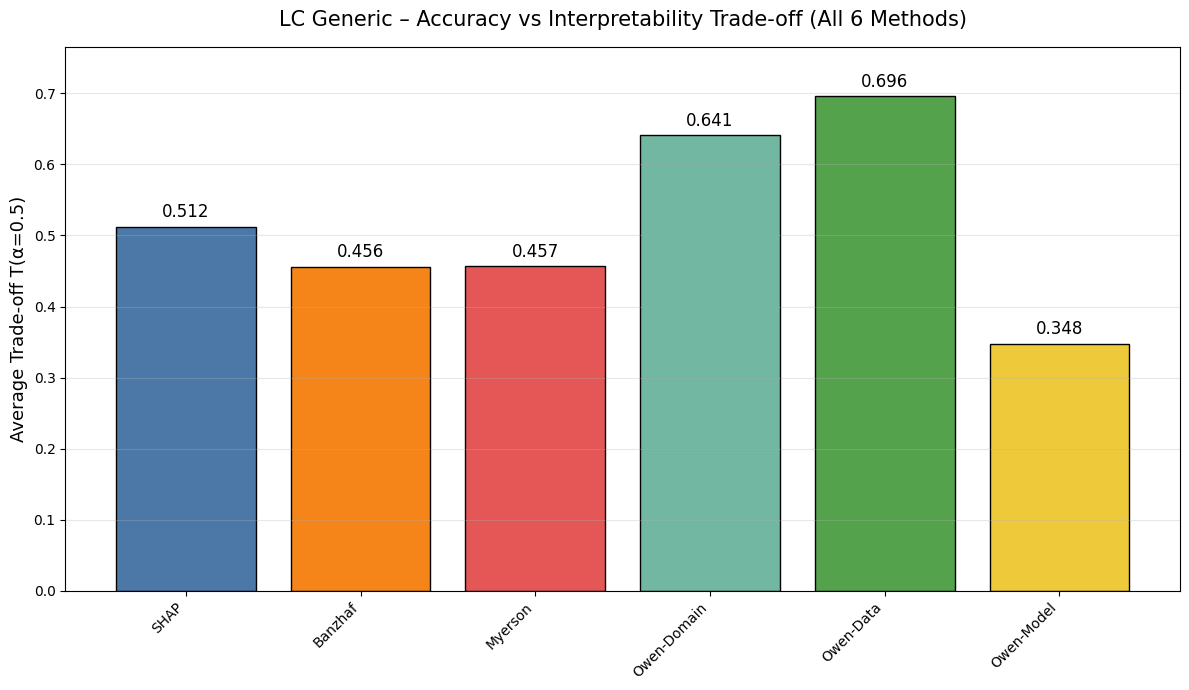

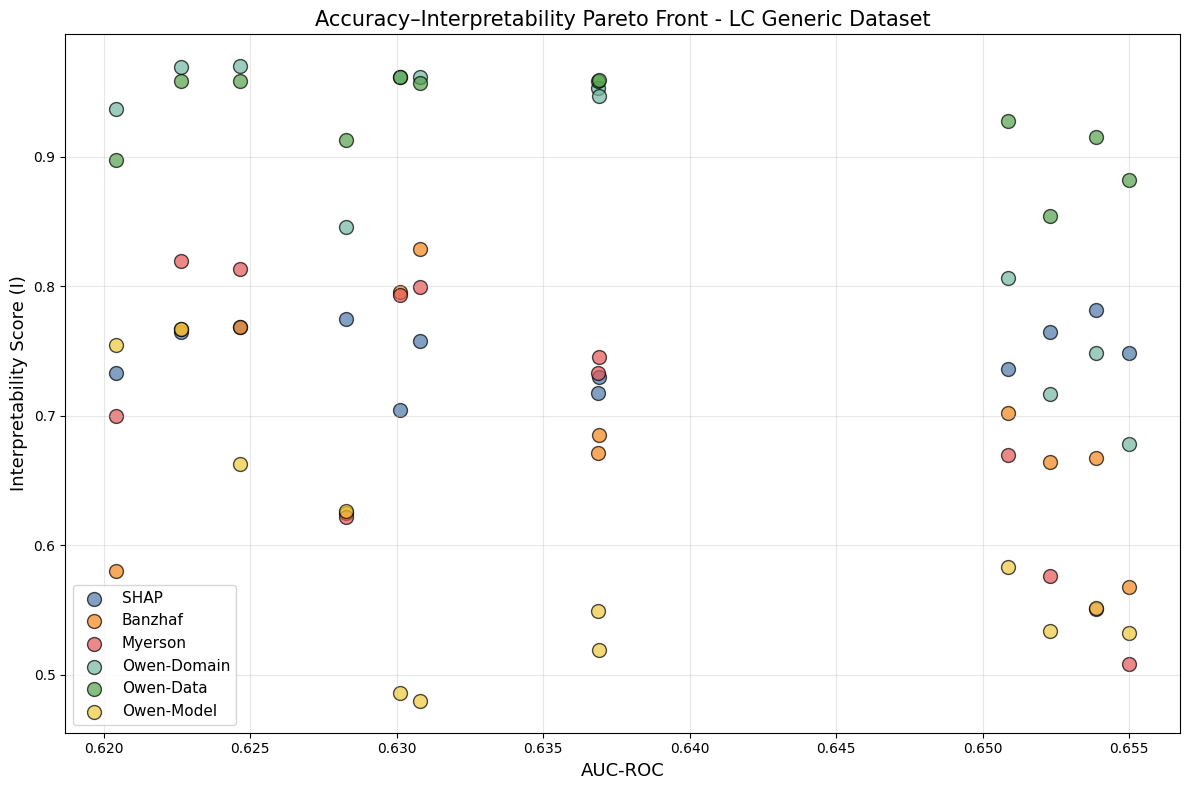

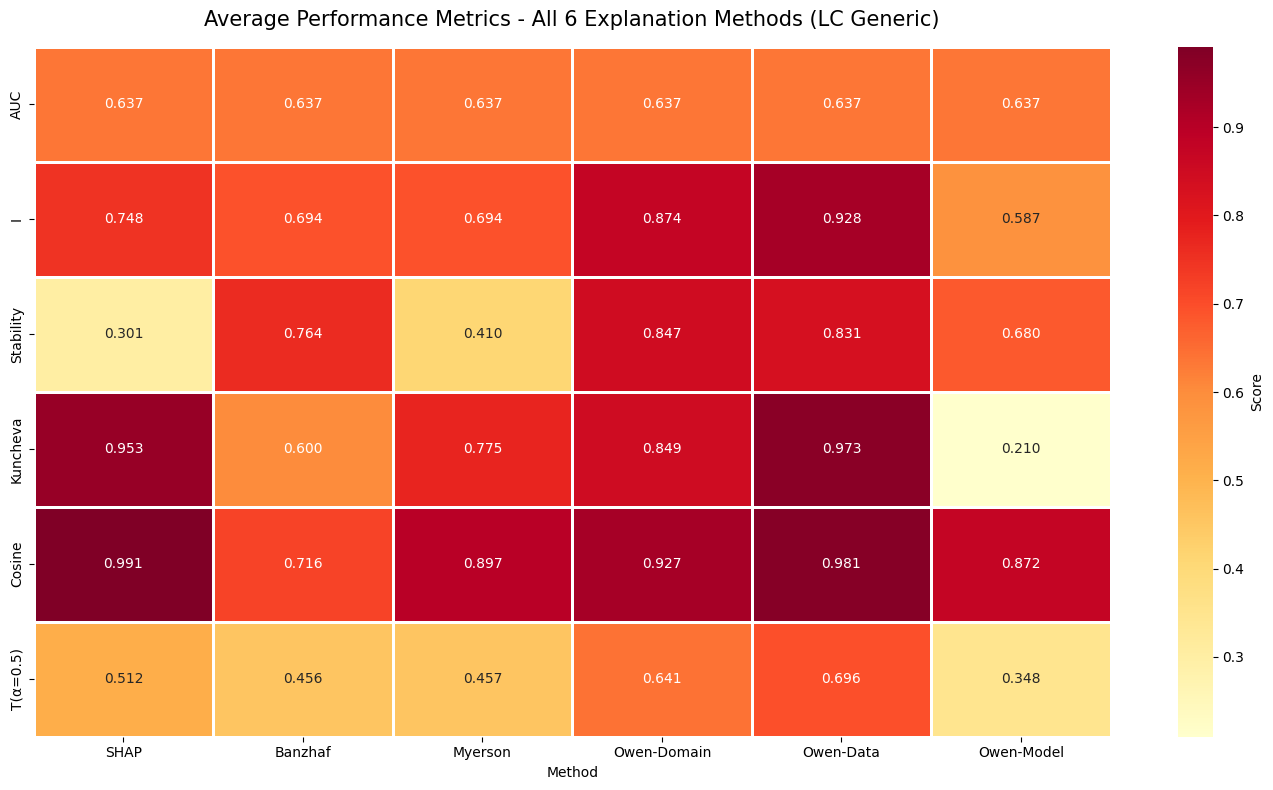

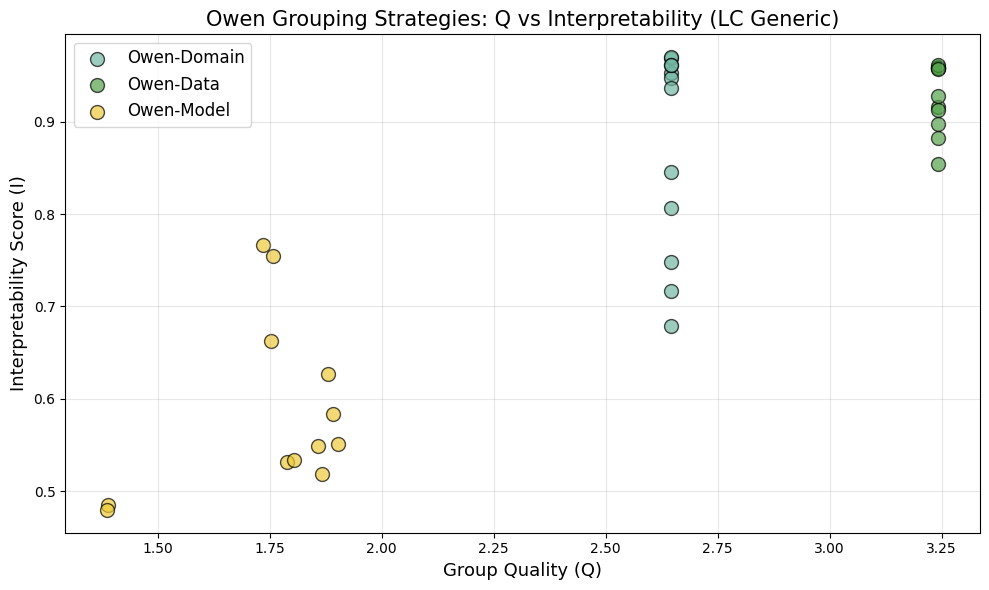


STATISTICAL ANALYSIS - ALL 6 METHODS (LC GENERIC)

Levene's Test for T(α=0.5) across methods:
Levene W = 1.0009, p = 0.424242

Shapiro–Wilk Normality Test per method (T and I):
  SHAP - T: W = 0.8843, p = 0.099462
  Banzhaf - T: W = 0.9487, p = 0.618089
  Myerson - T: W = 0.9326, p = 0.408253
  Owen-Domain - T: W = 0.9127, p = 0.230854
  Owen-Data - T: W = 0.9334, p = 0.417174
  Owen-Model - T: W = 0.8592, p = 0.047705
  SHAP - I: W = 0.9516, p = 0.659819
  Banzhaf - I: W = 0.9556, p = 0.719594
  Myerson - I: W = 0.9183, p = 0.272038
  Owen-Domain - I: W = 0.8099, p = 0.012184
  Owen-Data - I: W = 0.8444, p = 0.031307
  Owen-Model - I: W = 0.8767, p = 0.079429

Friedman Test for T(α=0.5):
Methods compared (T): ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
Friedman χ² = 40.6667, p = 0.000000
✓ SIGNIFICANT differences between methods on T(α=0.5)

Nemenyi Post-Hoc Test (p-values) for T(α=0.5):
             SHAP  Banzhaf  Myerson  Owen-Domain  Owen-Data  Owen-Mo

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [1]:
# ============================================================
# LENDING CLUB 10% default - UNIFIED GAME THEORY EXPLAINABILITY
# ============================================================

!pip install xgboost shap imbalanced-learn lightgbm scikit-posthocs seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD AND PREPROCESS LENDING CLUB DATASET (NEW CSV)
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING LENDING CLUB DATASET (GENERIC CSV)")
print("="*80)


csv_path = "LC_50K 10 pc df.csv"
# ---------------------------------------

df = pd.read_csv(csv_path)

# Ensure target column is named 'target'
if 'target' not in df.columns:
    if 'Default' in df.columns:
        df = df.rename(columns={'Default': 'target'})
    elif 'default' in df.columns:
        df = df.rename(columns={'default': 'target'})
    else:
        raise ValueError("No 'target' or 'Default' column found. Please rename your label column to 'target'.")

# Drop obvious ID / leakage columns if present
cols_to_drop = ['id', 'issue_d', 'zip_code', 'title', 'desc']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

# Handle missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

X = df.drop('target', axis=1)
y = df['target'].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns
cat_cols = ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols[:10]}...")

# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                          sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
fnames = preprocessor.get_feature_names_out()
print(f"\nNumber of processed features: {d}")
print(f"First 10 feature names: {fnames[:10]}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                             eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                              verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS (ALL 6 METHODS)
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values for a trained pipeline"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]  # binary
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance fallback...")
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc),
                                     n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    """Compute Banzhaf values"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def compute_myerson(pipe, X_test, G, alpha=0.5):
    """Compute Myerson values using feature graph"""
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(50, len(X_test)), 1))

# ============================================================
# 3B. OWEN GROUPING STRATEGIES ( LC DOMAIN GROUPS)
# ============================================================
def build_domain_groups_lc(fnames):
    """
    Improved LC domain groups based on financial semantics.
    """
    groups = {
        "Domain_EmploymentIncome": [],
        "Domain_LoanTerms": [],
        "Domain_CreditHistory": [],
        "Domain_Delinquency": [],
        "Domain_Utilization": [],
        "Domain_Purpose": [],
        "Domain_AssetsCollateral": [],
        "Domain_Location": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        # Employment & income / risk profile
        if any(k in lname for k in [
            "experience_c", "emp_length", "annual_inc", "revenue", "dti", "dti_n", "fico"
        ]):
            groups["Domain_EmploymentIncome"].append(i)

        # Loan terms & contract characteristics
        if any(k in lname for k in [
            "loan_amnt", "term", "installment", "int_rate"
        ]):
            groups["Domain_LoanTerms"].append(i)

        # Credit history & account structure
        if any(k in lname for k in [
            "open_acc", "total_acc", "revol_bal", "revol_util", "inq_last", "inq_last_6mths"
        ]):
            groups["Domain_CreditHistory"].append(i)

        # Delinquency / public records
        if any(k in lname for k in [
            "delinq", "pub_rec", "collections", "chargeoff"
        ]):
            groups["Domain_Delinquency"].append(i)

        # Utilization / revolving behavior
        if any(k in lname for k in [
            "revol_util", "revol_bal", "utilization"
        ]):
            groups["Domain_Utilization"].append(i)

        # Purpose of loan
        if "purpose" in lname:
            groups["Domain_Purpose"].append(i)

        # Assets / collateral
        if "home_ownership" in lname or "home_ownership_n" in lname:
            groups["Domain_AssetsCollateral"].append(i)

        # Location
        if "addr_state" in lname or "state" in lname:
            groups["Domain_Location"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    """Build data-driven groups using correlation clustering"""
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    """Build model-driven groups using SHAP correlation"""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    """Redistribute SHAP values using Owen grouping"""
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue

        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue

        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)

        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per

    return out

def compute_Q(groups, dep):
    """Compute group quality metric Q (within / across)"""
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except:
        return np.nan

# ============================================================
# 4. METRICS (CV, KUNCHEVA, COSINE, I, T)
# ============================================================
def stability_cv(expl_list):
    """Compute coefficient of variation stability metric"""
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """Compute Kuncheva index for feature consistency"""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Compute cosine directional consistency"""
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p+1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    """Compute overall interpretability score"""
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    """Normalize a series to [0,1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between AUC and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 5. UNIFIED EXPERIMENT LOOP (ALL 6 METHODS)
# ============================================================
print("\n" + "="*80)
print("STARTING UNIFIED EXPERIMENT - ALL 6 EXPLANATION METHODS (LC GENERIC)")
print("="*80)

# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
X_proc_full = preprocessor.transform(X)
corr_full = np.corrcoef(X_proc_full.T)
G_myerson = nx.Graph()
d_graph = corr_full.shape[0]
G_myerson.add_nodes_from(range(d_graph))
for i in range(d_graph):
    for j in range(i+1, d_graph):
        if abs(corr_full[i, j]) >= 0.25:
            G_myerson.add_edge(i, j, weight=corr_full[i, j])
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

# Setup cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_dom_runs, owen_data_runs, owen_model_runs = [], [], []
        Q_dom_list, Q_data_list, Q_model_list = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Train model once per fold
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            # Compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            # Sample instances for explanations
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # 1. SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"  SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((len(X_sample), n_features)))
                shap_vals = None

            # 2. Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=3, max_instances=3)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"  Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(3, len(X_sample)), n_features)))

            # 3. Myerson
            try:
                if shap_vals is not None:
                    myerson_vals = compute_myerson(pipe, X_sample, G_myerson)
                else:
                    myerson_vals = np.zeros((min(50, len(X_sample)), d))
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f"  Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # 4. Owen-Domain (improved LC domain groups)
            try:
                dom_groups = build_domain_groups_lc(fnames)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_dom = np.tile(owen_from_shap(phi, dom_groups), (len(X_sample), 1))
                else:
                    owen_dom = np.zeros((len(X_sample), d))
                owen_dom_runs.append(owen_dom)

                # Q for domain groups
                X_tr_proc = preprocessor.transform(X_tr)
                corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
                corr_tr = np.nan_to_num(corr_tr, nan=0.0)
                Q_dom_list.append(compute_Q(dom_groups, corr_tr))
            except Exception as e:
                print(f"  Owen-Domain failed: {e}")
                owen_dom_runs.append(np.zeros((len(X_sample), d)))
                Q_dom_list.append(np.nan)

            # 5. Owen-Data
            try:
                X_tr_proc = preprocessor.transform(X_tr)
                data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_data = np.tile(owen_from_shap(phi, data_groups), (len(X_sample), 1))
                else:
                    owen_data = np.zeros((len(X_sample), d))
                owen_data_runs.append(owen_data)
                Q_data_list.append(compute_Q(data_groups, dep_data))
            except Exception as e:
                print(f"  Owen-Data failed: {e}")
                owen_data_runs.append(np.zeros((len(X_sample), d)))
                Q_data_list.append(np.nan)

            # 6. Owen-Model
            try:
                if shap_vals is not None:
                    bg_sample = X_tr.sample(n=min(100, len(X_tr)), random_state=42)
                    shap_bg = get_shap_reliable(pipe, bg_sample)
                    model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)
                    phi = np.mean(shap_vals, axis=0)
                    owen_model = np.tile(owen_from_shap(phi, model_groups), (len(X_sample), 1))
                else:
                    owen_model = np.zeros((len(X_sample), d))
                    model_groups, dep_mod = {"Model_Default": list(range(d))}, np.eye(d)
                owen_model_runs.append(owen_model)
                Q_model_list.append(compute_Q(model_groups, dep_mod))
            except Exception as e:
                print(f"  Owen-Model failed: {e}")
                owen_model_runs.append(np.zeros((len(X_sample), d)))
                Q_model_list.append(np.nan)

        # Mean AUC for this model-sampler
        auc_mean = np.mean(aucs)

        # Metrics per explanation method
        explanation_methods = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen-Domain', owen_dom_runs),
            ('Owen-Data', owen_data_runs),
            ('Owen-Model', owen_model_runs)
        ]

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in explanation_methods:
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I_val = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Dataset': 'LC_Generic',
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I_val,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 6. PROCESS AND SAVE RESULTS
# ============================================================
if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\n" + "="*80)
    print("COMPLETE RESULTS - ALL 6 EXPLANATION METHODS (LC GENERIC)")
    print("="*80)
    print(metrics.round(4).to_string(index=False))

    metrics.to_csv('lc_generic_unified_results.csv', index=False)
    print("\n✓ Results saved to: lc_generic_unified_results.csv")
else:
    metrics = pd.DataFrame()
    print("No records produced.")

# ============================================================
# 7. VISUALIZATIONS (UNIFIED STYLE)
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    colors = {
        'SHAP': '#4C78A8',
        'Banzhaf': '#F58518',
        'Myerson': '#E45756',
        'Owen-Domain': '#72B7A2',
        'Owen-Data': '#54A24B',
        'Owen-Model': '#EECA3B'
    }

    method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

    # 1. Average Trade-off by Method
    plt.figure(figsize=(12, 7))
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().reindex(method_order)
    bars = plt.bar(method_avg.index, method_avg.values,
                   color=[colors[m] for m in method_avg.index], edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("LC Generic – Accuracy vs Interpretability Trade-off (All 6 Methods)",
              fontsize=15, pad=15)
    plt.ylim(0, method_avg.max() * 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('lc_generic_all_methods_tradeoff.png', dpi=300)
    plt.show()

    # 2. Pareto Front: AUC vs I
    plt.figure(figsize=(12, 8))
    for method in method_order:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(sub['AUC'], sub['I'], s=100, label=method,
                        color=colors[method], alpha=0.7, edgecolors='black')
    plt.xlabel("AUC-ROC", fontsize=13)
    plt.ylabel("Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front - LC Generic Dataset", fontsize=15)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('lc_generic_all_methods_pareto.png', dpi=300)
    plt.show()

    # 3. Heatmap of average metrics
    plt.figure(figsize=(14, 8))
    heatmap_data = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'I': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'T(α=0.5)': 'mean'
    }).reindex(method_order).T

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                linewidths=1, linecolor='white', cbar_kws={'label': 'Score'})
    plt.title("Average Performance Metrics - All 6 Explanation Methods (LC Generic)", fontsize=15, pad=15)
    plt.tight_layout()
    plt.savefig('lc_generic_all_methods_heatmap.png', dpi=300)
    plt.show()

    # 4. Owen Grouping Comparison (Q vs I)
    owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
    if any(m in metrics['Method'].unique() for m in owen_methods):
        plt.figure(figsize=(10, 6))
        owen_data_plot = metrics[metrics['Method'].isin(owen_methods)]

        for method in owen_methods:
            sub = owen_data_plot[owen_data_plot['Method'] == method]
            plt.scatter(sub['Q'], sub['I'], s=100, label=method,
                        color=colors[method], alpha=0.7, edgecolors='black')

        plt.xlabel("Group Quality (Q)", fontsize=13)
        plt.ylabel("Interpretability Score (I)", fontsize=13)
        plt.title("Owen Grouping Strategies: Q vs Interpretability (LC Generic)", fontsize=15)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('lc_generic_owen_q_vs_i_all.png', dpi=300)
        plt.show()

# ============================================================
# 8. STATISTICAL ANALYSIS (LEVENES, SHAPIRO, FRIEDMAN, NEMENYI,
#    WILCOXON, SPEARMAN, CLIFF'S DELTA ON T AND I)
# ============================================================
print("\n" + "="*80)
print("STATISTICAL ANALYSIS - ALL 6 METHODS (LC GENERIC)")
print("="*80)

from scipy.stats import friedmanchisquare, wilcoxon, levene, shapiro, spearmanr
import scikit_posthocs as sp

if not metrics.empty:
    # ---------- Helper: Cliff's Delta ----------
    def cliffs_delta(x, y):
        x = np.array(x)
        y = np.array(y)
        n1 = len(x)
        n2 = len(y)
        if n1 == 0 or n2 == 0:
            return np.nan
        greater = 0
        less = 0
        for xi in x:
            greater += np.sum(xi > y)
            less += np.sum(xi < y)
        delta = (greater - less) / (n1 * n2)
        return delta

    # ---------- Prepare per-method values ----------
    method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
    T_by_method = {m: metrics.loc[metrics['Method'] == m, 'T(α=0.5)'].values for m in method_order if m in metrics['Method'].unique()}
    I_by_method = {m: metrics.loc[metrics['Method'] == m, 'I'].values for m in method_order if m in metrics['Method'].unique()}

    # ---------- Levene's Test (homogeneity of variances) on T ----------
    print("\nLevene's Test for T(α=0.5) across methods:")
    if len(T_by_method) >= 2:
        lev_stat, lev_p = levene(*[v for v in T_by_method.values() if len(v) > 1])
        print(f"Levene W = {lev_stat:.4f}, p = {lev_p:.6f}")
    else:
        print("Not enough methods with data for Levene's test.")

    # ---------- Shapiro–Wilk Normality per method (T and I) ----------
    print("\nShapiro–Wilk Normality Test per method (T and I):")
    for m, vals in T_by_method.items():
        if len(vals) >= 3:
            stat_T, p_T = shapiro(vals)
            print(f"  {m} - T: W = {stat_T:.4f}, p = {p_T:.6f}")
        else:
            print(f"  {m} - T: insufficient samples for Shapiro–Wilk")

    for m, vals in I_by_method.items():
        if len(vals) >= 3:
            stat_I, p_I = shapiro(vals)
            print(f"  {m} - I: W = {stat_I:.4f}, p = {p_I:.6f}")
        else:
            print(f"  {m} - I: insufficient samples for Shapiro–Wilk")

    # ---------- Friedman Test for T(α=0.5) ----------
    print("\nFriedman Test for T(α=0.5):")
    pivot_T = metrics.pivot_table(
        values='T(α=0.5)',
        index=['Model', 'Sampler'],
        columns='Method',
        aggfunc='mean'
    )
    complete_methods_T = pivot_T.dropna(axis=1, how='any').columns.tolist()
    complete_methods_T = [m for m in method_order if m in complete_methods_T]

    if len(complete_methods_T) >= 3:
        data_matrix_T = pivot_T[complete_methods_T].values
        stat_T, p_T = friedmanchisquare(*[data_matrix_T[:, i] for i in range(data_matrix_T.shape[1])])
        print(f"Methods compared (T): {complete_methods_T}")
        print(f"Friedman χ² = {stat_T:.4f}, p = {p_T:.6f}")

        if p_T < 0.05:
            print("✓ SIGNIFICANT differences between methods on T(α=0.5)")
            nemenyi_T = sp.posthoc_nemenyi_friedman(data_matrix_T)
            print("\nNemenyi Post-Hoc Test (p-values) for T(α=0.5):")
            print(pd.DataFrame(nemenyi_T, index=complete_methods_T, columns=complete_methods_T).round(4))
        else:
            print("✗ No significant differences on T(α=0.5)")
    else:
        print("Insufficient complete data for Friedman test on T(α=0.5).")

    # ---------- Friedman Test for I ----------
    print("\nFriedman Test for Interpretability I:")
    pivot_I = metrics.pivot_table(
        values='I',
        index=['Model', 'Sampler'],
        columns='Method',
        aggfunc='mean'
    )
    complete_methods_I = pivot_I.dropna(axis=1, how='any').columns.tolist()
    complete_methods_I = [m for m in method_order if m in complete_methods_I]

    if len(complete_methods_I) >= 3:
        data_matrix_I = pivot_I[complete_methods_I].values
        stat_I, p_I = friedmanchisquare(*[data_matrix_I[:, i] for i in range(data_matrix_I.shape[1])])
        print(f"Methods compared (I): {complete_methods_I}")
        print(f"Friedman χ² = {stat_I:.4f}, p = {p_I:.6f}")

        if p_I < 0.05:
            print("✓ SIGNIFICANT differences between methods on I")
            nemenyi_I = sp.posthoc_nemenyi_friedman(data_matrix_I)
            print("\nNemenyi Post-Hoc Test (p-values) for I:")
            print(pd.DataFrame(nemenyi_I, index=complete_methods_I, columns=complete_methods_I).round(4))
        else:
            print("✗ No significant differences on I")
    else:
        print("Insufficient complete data for Friedman test on I.")

    # ---------- Wilcoxon Signed-Rank vs SHAP (T and I) ----------
    print("\nWilcoxon Signed-Rank Tests vs SHAP (paired on configurations):")
    baseline = 'SHAP'
    for metric_name in ['T(α=0.5)', 'I']:
        print(f"\nWilcoxon on {metric_name}:")
        for m in method_order:
            if m == baseline or m not in metrics['Method'].unique():
                continue
            # Align by (Model, Sampler)
            base_vals = metrics[metrics['Method'] == baseline].set_index(['Model', 'Sampler'])[metric_name]
            comp_vals = metrics[metrics['Method'] == m].set_index(['Model', 'Sampler'])[metric_name]
            common_idx = base_vals.index.intersection(comp_vals.index)
            if len(common_idx) < 3:
                print(f"  {m}: insufficient paired samples")
                continue
            b = base_vals.loc[common_idx].values
            c = comp_vals.loc[common_idx].values
            try:
                w_stat, w_p = wilcoxon(b, c)
                print(f"  {m} vs {baseline}: W = {w_stat:.4f}, p = {w_p:.6f}")
            except Exception as e:
                print(f"  {m} vs {baseline}: Wilcoxon failed ({e})")

    # ---------- Spearman Correlation ----------
    print("\nSpearman Correlations:")
    # AUC vs I, AUC vs T, I vs T
    rho_auc_I, p_auc_I = spearmanr(metrics['AUC'], metrics['I'])
    rho_auc_T, p_auc_T = spearmanr(metrics['AUC'], metrics['T(α=0.5)'])
    rho_I_T, p_I_T = spearmanr(metrics['I'], metrics['T(α=0.5)'])
    print(f"  Spearman(AUC, I): ρ = {rho_auc_I:.4f}, p = {p_auc_I:.6f}")
    print(f"  Spearman(AUC, T): ρ = {rho_auc_T:.4f}, p = {p_auc_T:.6f}")
    print(f"  Spearman(I, T):   ρ = {rho_I_T:.4f}, p = {p_I_T:.6f}")

    # Spearman correlation between methods on T and I
    print("\nSpearman correlation matrix across methods (T and I):")
    pivot_T_full = metrics.pivot_table(
        values='T(α=0.5)',
        index=['Model', 'Sampler'],
        columns='Method'
    )
    pivot_I_full = metrics.pivot_table(
        values='I',
        index=['Model', 'Sampler'],
        columns='Method'
    )
    corr_T = pivot_T_full.corr(method='spearman')
    corr_I = pivot_I_full.corr(method='spearman')
    print("\nSpearman on T(α=0.5):")
    print(corr_T.round(3))
    print("\nSpearman on I:")
    print(corr_I.round(3))

    # ---------- Cliff's Delta Effect Sizes on T and I ----------
    print("\nCliff's Delta Effect Sizes between methods (T and I):")

    methods_available = [m for m in method_order if m in metrics['Method'].unique()]

    # T
    print("\nCliff's Delta on T(α=0.5):")
    delta_T = pd.DataFrame(index=methods_available, columns=methods_available, dtype=float)
    for i, m1 in enumerate(methods_available):
        for j, m2 in enumerate(methods_available):
            if i == j:
                delta_T.loc[m1, m2] = 0.0
            else:
                x = T_by_method[m1]
                y = T_by_method[m2]
                delta_T.loc[m1, m2] = cliffs_delta(x, y)
    print(delta_T.round(3))

    # I
    print("\nCliff's Delta on I:")
    delta_I = pd.DataFrame(index=methods_available, columns=methods_available, dtype=float)
    for i, m1 in enumerate(methods_available):
        for j, m2 in enumerate(methods_available):
            if i == j:
                delta_I.loc[m1, m2] = 0.0
            else:
                x = I_by_method[m1]
                y = I_by_method[m2]
                delta_I.loc[m1, m2] = cliffs_delta(x, y)
    print(delta_I.round(3))

else:
    print("Metrics DataFrame is empty; skipping statistical analysis.")

# ============================================================
# 9. FEATURE & GROUPING ANALYSIS
# ============================================================
print("\n" + "="*80)
print("LENDING CLUB DATASET - FEATURE & GROUPING ANALYSIS (GENERIC)")
print("="*80)

# 1. ALL PROCESSED FEATURES WITH INDICES
print("\n" + "="*80)
print("1. ALL PROCESSED FEATURES WITH INDICES")
print("="*80)

feature_groups = {}
for i, fname in enumerate(fnames):
    found = False
    for cat_col in cat_cols:
        if cat_col in fname:
            if cat_col not in feature_groups:
                feature_groups[cat_col] = []
            feature_groups[cat_col].append((i, fname))
            found = True
            break

    if not found:
        for num_col in num_cols:
            if num_col == fname.replace('num__', ''):
                if num_col not in feature_groups:
                    feature_groups[num_col] = []
                feature_groups[num_col].append((i, fname))
                break

print("\nFEATURES BY ORIGINAL COLUMN:")
print("-" * 70)
for col in sorted(feature_groups.keys()):
    features = feature_groups[col]
    print(f"\n{col} ({len(features)} encoded features):")
    for idx, fname in sorted(features):
        clean_name = fname.replace('cat__', '').replace('num__', '')
        print(f"  [{idx:3d}] {clean_name}")

# 2. DOMAIN GROUPS ANALYSIS (IMPROVED LC)
print("\n\n" + "="*80)
print("2. DOMAIN GROUPS (IMPROVED LC SEMANTICS)")
print("="*80)

dom_groups_full = build_domain_groups_lc(fnames)
total_features_in_groups = sum(len(feats) for feats in dom_groups_full.values())
print(f"\nDomain groups cover {total_features_in_groups} out of {len(fnames)} features ({total_features_in_groups/len(fnames)*100:.1f}%)")

for group_name in sorted(dom_groups_full.keys()):
    features = sorted(dom_groups_full[group_name])
    print(f"\n{group_name} ({len(features)} features):")
    print("-" * 60)
    for idx in features[:20]:
        clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
        print(f"  [{idx:3d}] {clean_name}")
    if len(features) > 20:
        print(f"  ... and {len(features)-20} more features")

all_assigned = set()
for feats in dom_groups_full.values():
    all_assigned.update(feats)
unassigned = [i for i in range(len(fnames)) if i not in all_assigned]
if unassigned:
    print(f"\n⚠ {len(unassigned)} features not assigned to any domain group:")
    for idx in unassigned:
        clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
        print(f"  [{idx:3d}] {clean_name}")

# 3. DATA-DRIVEN GROUPS (Correlation Clustering)
print("\n\n" + "="*80)
print("3. DATA-DRIVEN GROUPS (Correlation Clustering)")
print("="*80)

sample_size = min(2000, len(X))
np.random.seed(42)
sample_idx = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[sample_idx]
X_proc_sample = preprocessor.transform(X_sample)

data_groups_full, corr_matrix_full = build_data_groups(X_proc_sample, n_groups=8)
print(f"\nData-driven clustering created {len(data_groups_full)} groups")
print(f"Correlation matrix shape: {corr_matrix_full.shape}")

for i, (group_name, features) in enumerate(sorted(data_groups_full.items())):
    features = sorted(features)
    print(f"\n{group_name} ({len(features)} features):")
    print("-" * 40)
    for idx in features[:15]:
        if idx < len(fnames):
            clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
            orig_col = "Unknown"
            for col in cat_cols + num_cols:
                if col in clean_name or clean_name == col:
                    orig_col = col
                    break
            print(f"  [{idx:3d}] {clean_name:35} | Orig: {orig_col}")
    if len(features) > 15:
        print(f"  ... and {len(features)-15} more features")

# 4. MODEL-DRIVEN GROUPS (SHAP Clustering)
print("\n\n" + "="*80)
print("4. MODEL-DRIVEN GROUPS (SHAP Clustering)")
print("="*80)

print("Training a sample model for SHAP clustering...")
np.random.seed(42)
train_size = min(1000, len(X))
train_idx = np.random.choice(len(X), train_size, replace=False)
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

simple_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
pipe_simple = ImbPipeline([('prep', preprocessor), ('clf', simple_model)])
pipe_simple.fit(X_train, y_train)

np.random.seed(42)
bg_size = min(200, len(X_train))
bg_sample = X_train.sample(n=bg_size)
shap_vals_full = get_shap_reliable(pipe_simple, bg_sample)

if shap_vals_full is not None and shap_vals_full.size > 0:
    model_groups_full, shap_corr_full = build_model_groups(shap_vals_full, n_groups=8)
    print(f"\nSHAP-based clustering created {len(model_groups_full)} groups")
    print(f"SHAP correlation matrix shape: {shap_corr_full.shape}")

    for i, (group_name, features) in enumerate(sorted(model_groups_full.items())):
        features = sorted(features)
        print(f"\n{group_name} ({len(features)} features):")
        print("-" * 40)
        for idx in features[:15]:
            if idx < len(fnames):
                clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
                orig_col = "Unknown"
                for col in cat_cols + num_cols:
                    if col in clean_name or clean_name == col:
                        orig_col = col
                        break
                if idx < shap_vals_full.shape[1]:
                    shap_importance = np.mean(np.abs(shap_vals_full[:, idx]))
                    print(f"  [{idx:3d}] {clean_name:30} | Orig: {orig_col:15} | SHAP: {shap_importance:.4f}")
                else:
                    print(f"  [{idx:3d}] {clean_name:30} | Orig: {orig_col}")
        if len(features) > 15:
            print(f"  ... and {len(features)-15} more features")
else:
    print("⚠ SHAP values could not be computed. Creating default model groups...")
    model_groups_full = {"Model_Default": list(range(len(fnames)))}
    shap_corr_full = np.eye(len(fnames))

# 5. GROUPING STRATEGY COMPARISON SUMMARY
print("\n\n" + "="*80)
print("5. GROUPING STRATEGY COMPARISON SUMMARY")
print("="*80)

from collections import Counter

all_groupings_full = {
    "Domain": dom_groups_full,
    "Data": data_groups_full,
    "Model": model_groups_full
}

summary_data = []
for strategy_name, groups in all_groupings_full.items():
    group_sizes = [len(feats) for feats in groups.values()]
    all_features = set()
    for feats in groups.values():
        all_features.update(feats)

    cat_feats = 0
    num_feats = 0
    for idx in all_features:
        if idx < len(fnames):
            fname = fnames[idx]
            if fname.startswith('cat__'):
                cat_feats += 1
            elif fname.startswith('num__'):
                num_feats += 1

    summary_data.append({
        'Strategy': strategy_name,
        'Num_Groups': len(groups),
        'Total_Features': len(all_features),
        'Coverage': f"{len(all_features)}/{len(fnames)} ({len(all_features)/len(fnames)*100:.1f}%)",
        'Avg_Group_Size': f"{np.mean(group_sizes):.1f}",
        'Std_Group_Size': f"{np.std(group_sizes):.1f}",
        'Min_Group_Size': min(group_sizes),
        'Max_Group_Size': max(group_sizes),
        'Cat_Features': cat_feats,
        'Num_Features': num_feats
    })

summary_df_full = pd.DataFrame(summary_data)
print("\n" + summary_df_full.to_string(index=False))

# 6. ORIGINAL DATASET STATISTICS
print("\n\n" + "="*80)
print("6. ORIGINAL DATASET STATISTICS")
print("="*80)

print("\nCategorical Features:")
print("-" * 40)
for col in cat_cols:
    unique_vals = X[col].nunique()
    print(f"{col:25} : {unique_vals:2d} unique values → {unique_vals-1} encoded features")
    if unique_vals <= 10:
        unique_samples = X[col].unique()[:5]
        print(f"  Sample values: {', '.join(map(str, unique_samples))}")

print("\nNumerical Features (Top 15):")
print("-" * 40)
for col in num_cols[:15]:
    stats_summary = X[col].describe()
    print(f"{col:25} : mean={stats_summary['mean']:.3f}, std={stats_summary['std']:.3f}, "
          f"min={stats_summary['min']:.3f}, max={stats_summary['max']:.3f}")
if len(num_cols) > 15:
    print(f"  ... and {len(num_cols)-15} more numerical features")

# 7. FEATURE IMPORTANCE PREVIEW
print("\n\n" + "="*80)
print("7. FEATURE IMPORTANCE PREVIEW (from sample model)")
print("="*80)

if shap_vals_full is not None and shap_vals_full.size > 0:
    shap_importance_full = np.mean(np.abs(shap_vals_full), axis=0)
    top_n = min(20, len(shap_importance_full))
    top_indices = np.argsort(shap_importance_full)[-top_n:][::-1]

    print(f"\nTop {top_n} Most Important Features (by mean |SHAP|):")
    print("-" * 80)
    print(f"{'Index':^6} | {'Feature':40} | {'Original Column':20} | {'Importance':>10}")
    print("-" * 80)

    for idx in top_indices:
        if idx < len(fnames):
            clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
            orig_col = "Unknown"
            for col in cat_cols + num_cols:
                if col in clean_name or clean_name == col:
                    orig_col = col
                    break
            importance = shap_importance_full[idx]
            print(f"{idx:6d} | {clean_name:40} | {orig_col:20} | {importance:10.6f}")

    print(f"\nTop Features by Domain Group:")
    print("-" * 60)
    for group_name in sorted(dom_groups_full.keys()):
        group_indices = dom_groups_full[group_name]
        if group_indices:
            group_importances = []
            for idx in group_indices:
                if idx < len(shap_importance_full):
                    group_importances.append((idx, shap_importance_full[idx]))
            if group_importances:
                group_importances.sort(key=lambda x: x[1], reverse=True)
                top_in_group = group_importances[:3]
                print(f"\n{group_name}:")
                for idx, imp in top_in_group:
                    clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
                    print(f"  [{idx:3d}] {clean_name:35} | Imp: {imp:.6f}")

print("\n" + "="*80)
print("FEATURE & GROUPING ANALYSIS COMPLETE - LC GENERIC DATASET")
print("="*80)



LOADING AND PREPROCESSING LENDING CLUB DATASET (GENERIC CSV)
Dataset shape: (50000, 10)
Target distribution: {0: 45000, 1: 5000}
Default rate: 10.00%
Imbalance ratio: 9.00:1

Categorical columns (5): ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
Numeric columns (4): ['revenue', 'dti_n', 'loan_amnt', 'fico_n']...

Number of processed features: 81
First 10 feature names: ['cat__experience_c_1' 'cat__emp_length_10+ years'
 'cat__emp_length_2 years' 'cat__emp_length_3 years'
 'cat__emp_length_4 years' 'cat__emp_length_5 years'
 'cat__emp_length_6 years' 'cat__emp_length_7 years'
 'cat__emp_length_8 years' 'cat__emp_length_9 years']

Class weights: {0: 0.5555555555555556, 1: 5.0}

STARTING UNIFIED EXPERIMENT - ALL 6 EXPLANATION METHODS (LC GENERIC)

Building feature graph for Myerson value...
Graph built with 81 nodes and 5 edges

Processing: RF + None
 Fold 1 | RF+None            → AUC: 0.6700
 Fold 2 | RF+None            → AUC: 0.6570
 Fold 3 | RF+None      

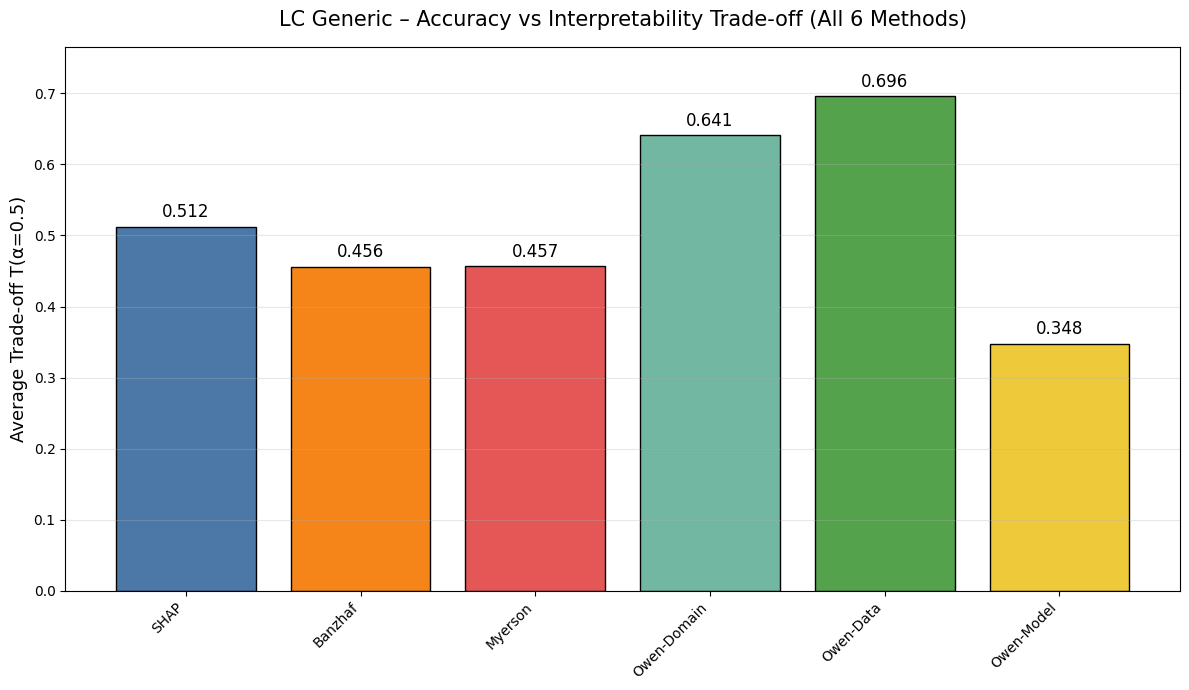

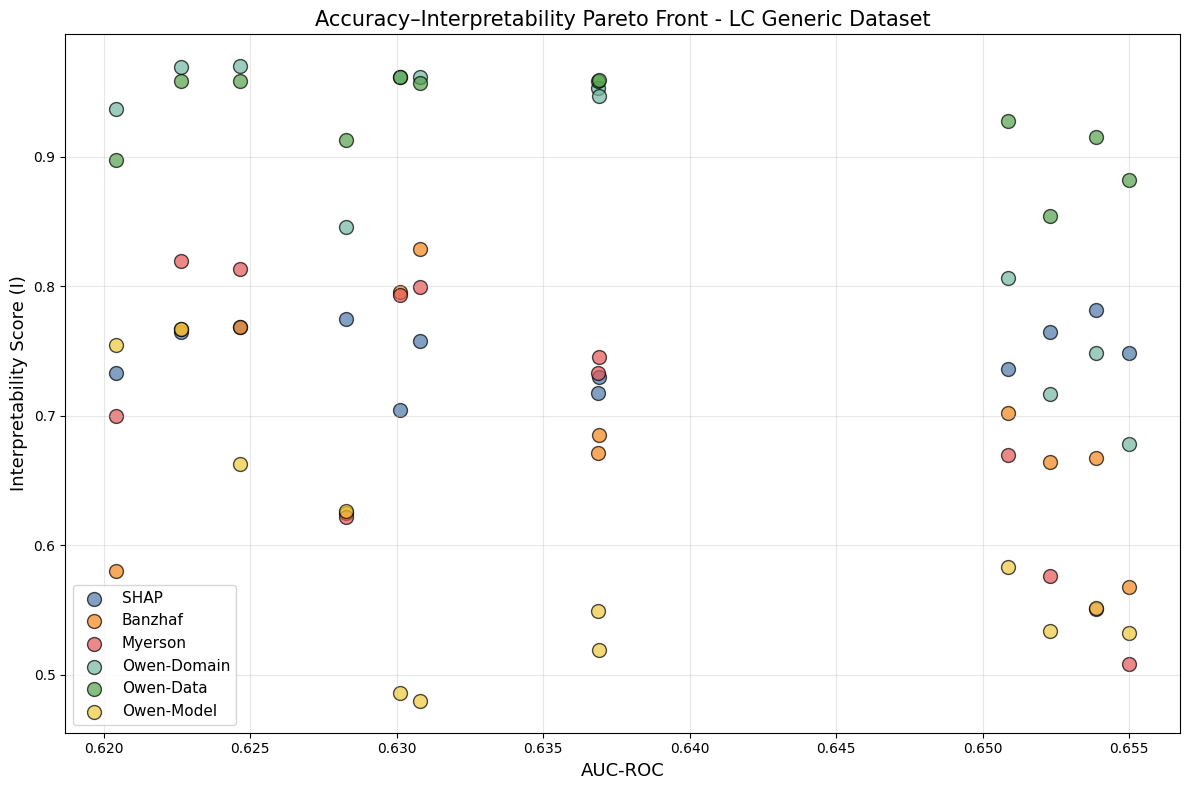

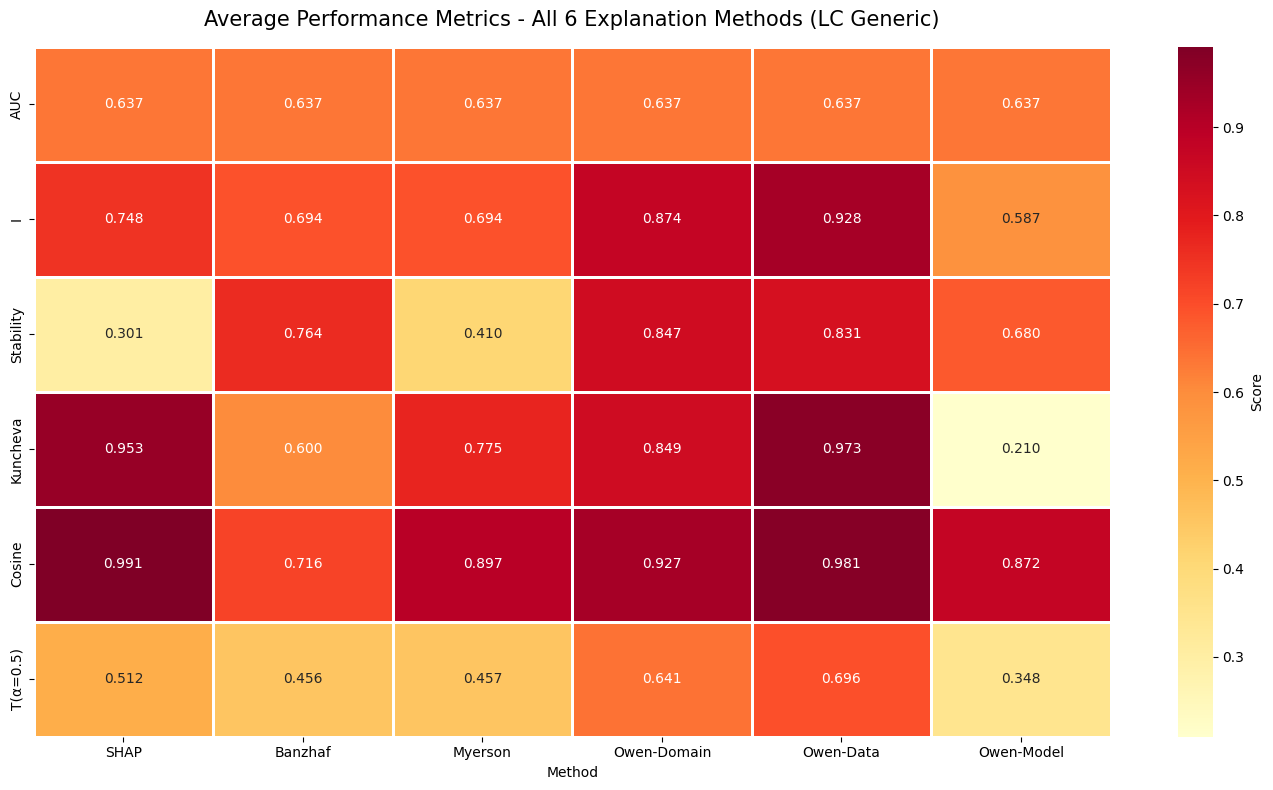

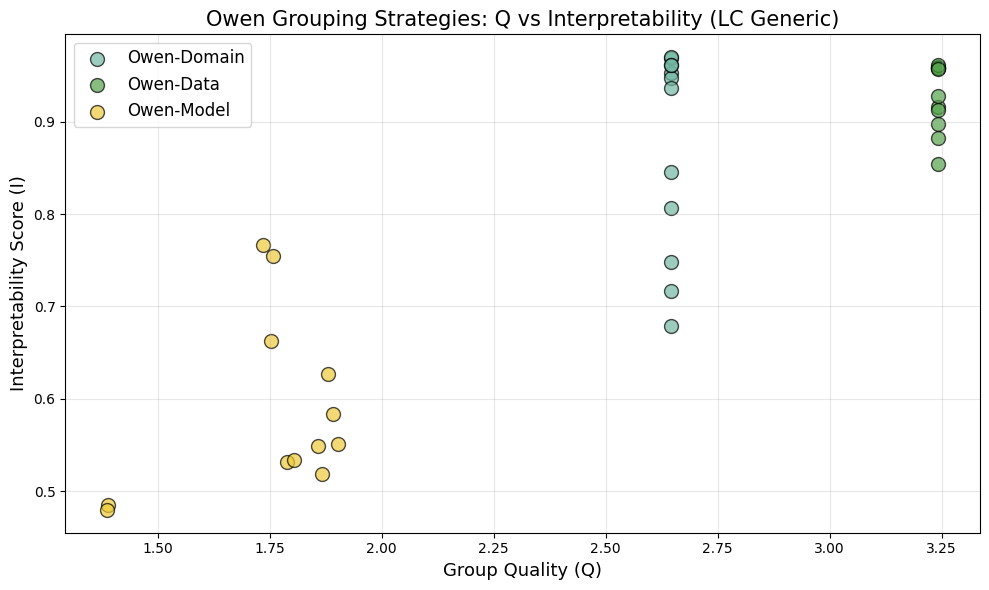


COMPREHENSIVE STATISTICAL ANALYSIS - LENDING CLUB DATASET

1. LEVENE'S TEST (Equal Variances)

T(α=0.5):
  W = 1.0009, p = 0.4242 → Equal variances ✓
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

I:
  W = 2.8222, p = 0.0227 → Unequal variances ✗
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

AUC:
  W = 0.0000, p = 1.0000 → Equal variances ✓
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

2. SHAPIRO-WILK NORMALITY TESTS

AUC:
  Banzhaf        : W = 0.8832, p = 0.0962 → Normal ✓
  Myerson        : W = 0.8832, p = 0.0962 → Normal ✓
  Owen-Data      : W = 0.8832, p = 0.0962 → Normal ✓
  Owen-Domain    : W = 0.8832, p = 0.0962 → Normal ✓
  Owen-Model     : W = 0.8832, p = 0.0962 → Normal ✓
  SHAP           : W = 0.8832, p = 0.0962 → Normal ✓

I:
  Banzhaf        : W = 0.9556, p = 0.7196 → Normal ✓
  Myerson        : W = 0.9183, p = 0.2720 → Normal ✓
 

In [2]:
# ============================================================
# LENDING CLUB 10% default - UNIFIED GAME THEORY EXPLAINABILITY
# ============================================================

!pip install xgboost shap imbalanced-learn lightgbm scikit-posthocs seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD AND PREPROCESS LENDING CLUB DATASET (NEW CSV)
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING LENDING CLUB DATASET (GENERIC CSV)")
print("="*80)

csv_path = "LC_50K 10 pc df.csv"

df = pd.read_csv(csv_path)

# Ensure target column is named 'target'
if 'target' not in df.columns:
    if 'Default' in df.columns:
        df = df.rename(columns={'Default': 'target'})
    elif 'default' in df.columns:
        df = df.rename(columns={'default': 'target'})
    else:
        raise ValueError("No 'target' or 'Default' column found. Please rename your label column to 'target'.")

# Drop obvious ID / leakage columns if present
cols_to_drop = ['id', 'issue_d', 'zip_code', 'title', 'desc']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

# Handle missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

X = df.drop('target', axis=1)
y = df['target'].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns
cat_cols = ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols[:10]}...")

# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                          sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
fnames = preprocessor.get_feature_names_out()
print(f"\nNumber of processed features: {d}")
print(f"First 10 feature names: {fnames[:10]}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                             eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                              verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS (ALL 6 METHODS)
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values for a trained pipeline"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]  # binary
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance fallback...")
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc),
                                     n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    """Compute Banzhaf values"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def compute_myerson(pipe, X_test, G, alpha=0.5):
    """Compute Myerson values using feature graph"""
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(50, len(X_test)), 1))

# ============================================================
# 3B. OWEN GROUPING STRATEGIES ( LC DOMAIN GROUPS)
# ============================================================
def build_domain_groups_lc(fnames):
    """
    Improved LC domain groups based on financial semantics.
    """
    groups = {
        "Domain_EmploymentIncome": [],
        "Domain_LoanTerms": [],
        "Domain_CreditHistory": [],
        "Domain_Delinquency": [],
        "Domain_Utilization": [],
        "Domain_Purpose": [],
        "Domain_AssetsCollateral": [],
        "Domain_Location": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        # Employment & income / risk profile
        if any(k in lname for k in [
            "experience_c", "emp_length", "annual_inc", "revenue", "dti", "dti_n", "fico"
        ]):
            groups["Domain_EmploymentIncome"].append(i)

        # Loan terms & contract characteristics
        if any(k in lname for k in [
            "loan_amnt", "term", "installment", "int_rate"
        ]):
            groups["Domain_LoanTerms"].append(i)

        # Credit history & account structure
        if any(k in lname for k in [
            "open_acc", "total_acc", "revol_bal", "revol_util", "inq_last", "inq_last_6mths"
        ]):
            groups["Domain_CreditHistory"].append(i)

        # Delinquency / public records
        if any(k in lname for k in [
            "delinq", "pub_rec", "collections", "chargeoff"
        ]):
            groups["Domain_Delinquency"].append(i)

        # Utilization / revolving behavior
        if any(k in lname for k in [
            "revol_util", "revol_bal", "utilization"
        ]):
            groups["Domain_Utilization"].append(i)

        # Purpose of loan
        if "purpose" in lname:
            groups["Domain_Purpose"].append(i)

        # Assets / collateral
        if "home_ownership" in lname or "home_ownership_n" in lname:
            groups["Domain_AssetsCollateral"].append(i)

        # Location
        if "addr_state" in lname or "state" in lname:
            groups["Domain_Location"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    """Build data-driven groups using correlation clustering"""
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    """Build model-driven groups using SHAP correlation"""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    """Redistribute SHAP values using Owen grouping"""
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue

        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue

        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)

        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per

    return out

def compute_Q(groups, dep):
    """Compute group quality metric Q (within / across)"""
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except:
        return np.nan

# ============================================================
# 4. METRICS (CV, KUNCHEVA, COSINE, I, T)
# ============================================================
def stability_cv(expl_list):
    """Compute coefficient of variation stability metric"""
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """Compute Kuncheva index for feature consistency"""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Compute cosine directional consistency"""
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p+1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    """Compute overall interpretability score"""
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    """Normalize a series to [0,1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between AUC and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 5. UNIFIED EXPERIMENT LOOP (ALL 6 METHODS)
# ============================================================
print("\n" + "="*80)
print("STARTING UNIFIED EXPERIMENT - ALL 6 EXPLANATION METHODS (LC GENERIC)")
print("="*80)

# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
X_proc_full = preprocessor.transform(X)
corr_full = np.corrcoef(X_proc_full.T)
G_myerson = nx.Graph()
d_graph = corr_full.shape[0]
G_myerson.add_nodes_from(range(d_graph))
for i in range(d_graph):
    for j in range(i+1, d_graph):
        if abs(corr_full[i, j]) >= 0.25:
            G_myerson.add_edge(i, j, weight=corr_full[i, j])
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

# Setup cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_dom_runs, owen_data_runs, owen_model_runs = [], [], []
        Q_dom_list, Q_data_list, Q_model_list = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Train model once per fold
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            # Compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            # Sample instances for explanations
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # 1. SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"  SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((len(X_sample), n_features)))
                shap_vals = None

            # 2. Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=3, max_instances=3)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"  Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(3, len(X_sample)), n_features)))

            # 3. Myerson
            try:
                if shap_vals is not None:
                    myerson_vals = compute_myerson(pipe, X_sample, G_myerson)
                else:
                    myerson_vals = np.zeros((min(50, len(X_sample)), d))
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f"  Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # 4. Owen-Domain (improved LC domain groups)
            try:
                dom_groups = build_domain_groups_lc(fnames)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_dom = np.tile(owen_from_shap(phi, dom_groups), (len(X_sample), 1))
                else:
                    owen_dom = np.zeros((len(X_sample), d))
                owen_dom_runs.append(owen_dom)

                # Q for domain groups
                X_tr_proc = preprocessor.transform(X_tr)
                corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
                corr_tr = np.nan_to_num(corr_tr, nan=0.0)
                Q_dom_list.append(compute_Q(dom_groups, corr_tr))
            except Exception as e:
                print(f"  Owen-Domain failed: {e}")
                owen_dom_runs.append(np.zeros((len(X_sample), d)))
                Q_dom_list.append(np.nan)

            # 5. Owen-Data
            try:
                X_tr_proc = preprocessor.transform(X_tr)
                data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_data = np.tile(owen_from_shap(phi, data_groups), (len(X_sample), 1))
                else:
                    owen_data = np.zeros((len(X_sample), d))
                owen_data_runs.append(owen_data)
                Q_data_list.append(compute_Q(data_groups, dep_data))
            except Exception as e:
                print(f"  Owen-Data failed: {e}")
                owen_data_runs.append(np.zeros((len(X_sample), d)))
                Q_data_list.append(np.nan)

            # 6. Owen-Model
            try:
                if shap_vals is not None:
                    bg_sample = X_tr.sample(n=min(100, len(X_tr)), random_state=42)
                    shap_bg = get_shap_reliable(pipe, bg_sample)
                    model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)
                    phi = np.mean(shap_vals, axis=0)
                    owen_model = np.tile(owen_from_shap(phi, model_groups), (len(X_sample), 1))
                else:
                    owen_model = np.zeros((len(X_sample), d))
                    model_groups, dep_mod = {"Model_Default": list(range(d))}, np.eye(d)
                owen_model_runs.append(owen_model)
                Q_model_list.append(compute_Q(model_groups, dep_mod))
            except Exception as e:
                print(f"  Owen-Model failed: {e}")
                owen_model_runs.append(np.zeros((len(X_sample), d)))
                Q_model_list.append(np.nan)

        # Mean AUC for this model-sampler
        auc_mean = np.mean(aucs)

        # Metrics per explanation method
        explanation_methods = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen-Domain', owen_dom_runs),
            ('Owen-Data', owen_data_runs),
            ('Owen-Model', owen_model_runs)
        ]

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in explanation_methods:
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I_val = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Dataset': 'LC_Generic',
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I_val,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 6. PROCESS AND SAVE RESULTS
# ============================================================
if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\n" + "="*80)
    print("COMPLETE RESULTS - ALL 6 EXPLANATION METHODS (LC GENERIC)")
    print("="*80)
    print(metrics.round(4).to_string(index=False))

    metrics.to_csv('lc_generic_unified_results.csv', index=False)
    print("\n✓ Results saved to: lc_generic_unified_results.csv")
else:
    metrics = pd.DataFrame()
    print("No records produced.")

# ============================================================
# 7. VISUALIZATIONS (UNIFIED STYLE)
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    colors = {
        'SHAP': '#4C78A8',
        'Banzhaf': '#F58518',
        'Myerson': '#E45756',
        'Owen-Domain': '#72B7A2',
        'Owen-Data': '#54A24B',
        'Owen-Model': '#EECA3B'
    }

    method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

    # 1. Average Trade-off by Method
    plt.figure(figsize=(12, 7))
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().reindex(method_order)
    bars = plt.bar(method_avg.index, method_avg.values,
                   color=[colors[m] for m in method_avg.index], edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("LC Generic – Accuracy vs Interpretability Trade-off (All 6 Methods)",
              fontsize=15, pad=15)
    plt.ylim(0, method_avg.max() * 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('lc_generic_all_methods_tradeoff.png', dpi=300)
    plt.show()

    # 2. Pareto Front: AUC vs I
    plt.figure(figsize=(12, 8))
    for method in method_order:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(sub['AUC'], sub['I'], s=100, label=method,
                        color=colors[method], alpha=0.7, edgecolors='black')
    plt.xlabel("AUC-ROC", fontsize=13)
    plt.ylabel("Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front - LC Generic Dataset", fontsize=15)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('lc_generic_all_methods_pareto.png', dpi=300)
    plt.show()

    # 3. Heatmap of average metrics
    plt.figure(figsize=(14, 8))
    heatmap_data = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'I': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'T(α=0.5)': 'mean'
    }).reindex(method_order).T

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                linewidths=1, linecolor='white', cbar_kws={'label': 'Score'})
    plt.title("Average Performance Metrics - All 6 Explanation Methods (LC Generic)", fontsize=15, pad=15)
    plt.tight_layout()
    plt.savefig('lc_generic_all_methods_heatmap.png', dpi=300)
    plt.show()

    # 4. Owen Grouping Comparison (Q vs I)
    owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
    if any(m in metrics['Method'].unique() for m in owen_methods):
        plt.figure(figsize=(10, 6))
        owen_data_plot = metrics[metrics['Method'].isin(owen_methods)]

        for method in owen_methods:
            sub = owen_data_plot[owen_data_plot['Method'] == method]
            plt.scatter(sub['Q'], sub['I'], s=100, label=method,
                        color=colors[method], alpha=0.7, edgecolors='black')

        plt.xlabel("Group Quality (Q)", fontsize=13)
        plt.ylabel("Interpretability Score (I)", fontsize=13)
        plt.title("Owen Grouping Strategies: Q vs Interpretability (LC Generic)", fontsize=15)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('lc_generic_owen_q_vs_i_all.png', dpi=300)
        plt.show()

# ============================================================
# 8. COMPREHENSIVE STATISTICAL ANALYSIS (IMPROVED OUTPUT)
# ============================================================
print("\n" + "="*80)
print("COMPREHENSIVE STATISTICAL ANALYSIS - LENDING CLUB DATASET")
print("="*80)

from scipy.stats import friedmanchisquare, wilcoxon, levene, shapiro, spearmanr
import scikit_posthocs as sp

if not metrics.empty:
    # ---------- Helper: Cliff's Delta ----------
    def cliffs_delta(x, y):
        x = np.array(x)
        y = np.array(y)
        n1 = len(x)
        n2 = len(y)
        if n1 == 0 or n2 == 0:
            return np.nan
        greater = 0
        less = 0
        for xi in x:
            greater += np.sum(xi > y)
            less += np.sum(xi < y)
        delta = (greater - less) / (n1 * n2)
        return delta

    def interpret_delta(delta):
        """Interpret Cliff's delta magnitude"""
        abs_delta = abs(delta)
        if abs_delta < 0.147: return "negligible"
        elif abs_delta < 0.33: return "small"
        elif abs_delta < 0.474: return "medium"
        else: return "large"

    # ---------- Prepare per-method values ----------
    method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
    T_by_method = {m: metrics.loc[metrics['Method'] == m, 'T(α=0.5)'].values for m in method_order if m in metrics['Method'].unique()}
    I_by_method = {m: metrics.loc[metrics['Method'] == m, 'I'].values for m in method_order if m in metrics['Method'].unique()}
    AUC_by_method = {m: metrics.loc[metrics['Method'] == m, 'AUC'].values for m in method_order if m in metrics['Method'].unique()}
    Stability_by_method = {m: metrics.loc[metrics['Method'] == m, 'Stability'].values for m in method_order if m in metrics['Method'].unique()}
    Kuncheva_by_method = {m: metrics.loc[metrics['Method'] == m, 'Kuncheva'].values for m in method_order if m in metrics['Method'].unique()}
    Cosine_by_method = {m: metrics.loc[metrics['Method'] == m, 'Cosine'].values for m in method_order if m in metrics['Method'].unique()}

    # ============================================================
    # 1. LEVENE'S TEST (Equal Variances)
    # ============================================================
    print("\n" + "="*80)
    print("1. LEVENE'S TEST (Equal Variances)")
    print("="*80)

    for metric_name, data_dict in [('T(α=0.5)', T_by_method), ('I', I_by_method), ('AUC', AUC_by_method)]:
        print(f"\n{metric_name}:")
        groups = []
        group_labels = []

        for method in method_order:
            data = data_dict.get(method, [])
            if len(data) >= 3:
                groups.append(data)
                group_labels.append(method)

        if len(groups) >= 2:
            try:
                stat, p_value = levene(*groups)
                result = "Equal variances ✓" if p_value > 0.05 else "Unequal variances ✗"
                print(f"  W = {stat:.4f}, p = {p_value:.4f} → {result}")
                print(f"  Methods compared: {group_labels}")
            except Exception as e:
                print(f"  Could not compute: {e}")
        else:
            print(f"  Insufficient data for Levene's test")

    # ============================================================
    # 2. SHAPIRO-WILK NORMALITY TESTS
    # ============================================================
    print("\n" + "="*80)
    print("2. SHAPIRO-WILK NORMALITY TESTS")
    print("="*80)

    metric_dicts = {
        'AUC': AUC_by_method,
        'I': I_by_method,
        'T(α=0.5)': T_by_method,
        'Stability': Stability_by_method,
        'Kuncheva': Kuncheva_by_method,
        'Cosine': Cosine_by_method
    }

    for metric_name, data_dict in metric_dicts.items():
        print(f"\n{metric_name}:")
        for method in sorted(method_order):
            data = data_dict.get(method, [])
            if len(data) >= 3 and len(data) <= 5000:
                try:
                    stat, p_value = shapiro(data)
                    normal = "Normal ✓" if p_value > 0.05 else "Non-normal ✗"
                    print(f"  {method:15}: W = {stat:.4f}, p = {p_value:.4f} → {normal}")
                except Exception as e:
                    print(f"  {method:15}: Could not compute ({e})")
            elif method in data_dict:
                print(f"  {method:15}: insufficient samples ({len(data)})")

    # ============================================================
    # 3. SPEARMAN CORRELATION (AUC vs I)
    # ============================================================
    print("\n" + "="*80)
    print("3. SPEARMAN CORRELATION (AUC vs Interpretability)")
    print("="*80)

    # Overall correlation
    print("\nOverall Correlation:")
    rho, p_value = spearmanr(metrics['AUC'], metrics['I'])
    sig = "✓" if p_value < 0.05 else "✗"
    direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
    strength = "Strong" if abs(rho) >= 0.7 else "Moderate" if abs(rho) >= 0.3 else "Weak"
    print(f"  ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")

    # By method
    print("\nCorrelation by Method:")
    for method in sorted(method_order):
        subset = metrics[metrics['Method'] == method]
        if len(subset) >= 3:
            rho, p_value = spearmanr(subset['AUC'], subset['I'])
            sig = "✓" if p_value < 0.05 else "✗"
            direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
            strength = "Strong" if abs(rho) >= 0.7 else "Moderate" if abs(rho) >= 0.3 else "Weak"
            print(f"  {method:15}: ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")
        elif method in metrics['Method'].unique():
            print(f"  {method:15}: insufficient samples")

    # ============================================================
    # 4. CLIFF'S DELTA EFFECT SIZES
    # ============================================================
    print("\n" + "="*80)
    print("4. CLIFF'S DELTA EFFECT SIZES")
    print("="*80)

    # Key pairwise comparisons
    key_pairs = [
        ('SHAP', 'Banzhaf'),
        ('SHAP', 'Myerson'),
        ('SHAP', 'Owen-Domain'),
        ('SHAP', 'Owen-Data'),
        ('SHAP', 'Owen-Model'),
        ('Owen-Domain', 'Owen-Data'),
        ('Owen-Domain', 'Owen-Model'),
        ('Owen-Data', 'Owen-Model'),
        ('Banzhaf', 'Myerson')
    ]

    print("\nTrade-off (T) Effect Sizes:")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            data1 = T_by_method.get(method1, [])
            data2 = T_by_method.get(method2, [])

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                print(f"  {method1:15} vs {method2:15}: δ = {delta:.4f} ({magnitude}, {direction})")
            else:
                print(f"  {method1:15} vs {method2:15}: insufficient data")

    print("\nInterpretability (I) Effect Sizes:")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            data1 = I_by_method.get(method1, [])
            data2 = I_by_method.get(method2, [])

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                print(f"  {method1:15} vs {method2:15}: δ = {delta:.4f} ({magnitude}, {direction})")
            else:
                print(f"  {method1:15} vs {method2:15}: insufficient data")

    # ============================================================
    # 5. FRIEDMAN & NEMENYI TESTS
    # ============================================================
    print("\n" + "="*80)
    print("5. FRIEDMAN & NEMENYI TESTS")
    print("="*80)

    # Friedman test for T(α=0.5)
    print("\nFriedman Test for T(α=0.5):")
    pivoted_T = metrics.pivot_table(
        values='T(α=0.5)',
        index=['Model', 'Sampler'],
        columns='Method',
        aggfunc='mean'
    )

    # Keep only methods with complete data
    complete_methods_T = pivoted_T.dropna(axis=1, how='any').columns.tolist()
    complete_methods_T = [m for m in method_order if m in complete_methods_T]

    if len(complete_methods_T) >= 3:
        data_matrix_T = pivoted_T[complete_methods_T].values
        stat_T, p_T = friedmanchisquare(*[data_matrix_T[:, i] for i in range(data_matrix_T.shape[1])])
        print(f"Methods compared: {complete_methods_T}")
        print(f"Friedman χ² = {stat_T:.4f}, p = {p_T:.6f}")

        if p_T < 0.05:
            print("✓ SIGNIFICANT differences between methods")
            nemenyi_T = sp.posthoc_nemenyi_friedman(data_matrix_T)
            print("\nNemenyi Post-Hoc Test (p-values) for T(α=0.5):")
            # Create readable DataFrame
            nemenyi_df = pd.DataFrame(nemenyi_T, index=complete_methods_T, columns=complete_methods_T)
            print(nemenyi_df.round(4))
        else:
            print("✗ No significant differences")
    else:
        print("Insufficient complete data for Friedman test")

    # Friedman test for I
    print("\nFriedman Test for Interpretability I:")
    pivoted_I = metrics.pivot_table(
        values='I',
        index=['Model', 'Sampler'],
        columns='Method',
        aggfunc='mean'
    )

    complete_methods_I = pivoted_I.dropna(axis=1, how='any').columns.tolist()
    complete_methods_I = [m for m in method_order if m in complete_methods_I]

    if len(complete_methods_I) >= 3:
        data_matrix_I = pivoted_I[complete_methods_I].values
        stat_I, p_I = friedmanchisquare(*[data_matrix_I[:, i] for i in range(data_matrix_I.shape[1])])
        print(f"Methods compared: {complete_methods_I}")
        print(f"Friedman χ² = {stat_I:.4f}, p = {p_I:.6f}")

        if p_I < 0.05:
            print("✓ SIGNIFICANT differences between methods")
            nemenyi_I = sp.posthoc_nemenyi_friedman(data_matrix_I)
            print("\nNemenyi Post-Hoc Test (p-values) for I:")
            nemenyi_df_I = pd.DataFrame(nemenyi_I, index=complete_methods_I, columns=complete_methods_I)
            print(nemenyi_df_I.round(4))
        else:
            print("✗ No significant differences")
    else:
        print("Insufficient complete data for Friedman test")

    # ============================================================
    # 6. WILCOXON SIGNED-RANK TESTS
    # ============================================================
    print("\n" + "="*80)
    print("6. WILCOXON SIGNED-RANK TESTS")
    print("="*80)

    print("\nWilcoxon Tests for T(α=0.5):")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            # Align by (Model, Sampler)
            base_vals = metrics[metrics['Method'] == method1].set_index(['Model', 'Sampler'])['T(α=0.5)']
            comp_vals = metrics[metrics['Method'] == method2].set_index(['Model', 'Sampler'])['T(α=0.5)']
            common_idx = base_vals.index.intersection(comp_vals.index)

            if len(common_idx) >= 3:
                b = base_vals.loc[common_idx].values
                c = comp_vals.loc[common_idx].values
                try:
                    w_stat, w_p = wilcoxon(b, c)
                    sig = "✓" if w_p < 0.05 else "✗"
                    mean1, mean2 = np.mean(b), np.mean(c)
                    print(f"  {method1:15} vs {method2:15}: W = {w_stat:.4f}, p = {w_p:.6f} {sig} (means: {mean1:.3f} vs {mean2:.3f})")
                except Exception as e:
                    print(f"  {method1:15} vs {method2:15}: Wilcoxon failed ({e})")
            else:
                print(f"  {method1:15} vs {method2:15}: insufficient paired samples")

    # ============================================================
    # 7. SUMMARY STATISTICS
    # ============================================================
    print("\n" + "="*80)
    print("7. SUMMARY STATISTICS BY METHOD")
    print("="*80)

    summary = metrics.groupby('Method').agg({
        'AUC': ['mean', 'std', 'count'],
        'I': ['mean', 'std'],
        'Stability': ['mean', 'std'],
        'Kuncheva': ['mean', 'std'],
        'Cosine': ['mean', 'std'],
        'T(α=0.5)': ['mean', 'std', 'min', 'max']
    }).round(4)

    print("\nPerformance Summary (mean ± standard deviation):")
    print(summary.to_string())

    # Best and worst methods
    print("\n" + "="*80)
    print("BEST AND WORST PERFORMING METHODS")
    print("="*80)

    for metric in ['AUC', 'I', 'T(α=0.5)']:
        if metric in metrics.columns:
            metric_means = metrics.groupby('Method')[metric].mean()
            if len(metric_means) > 0:
                best_method = metric_means.idxmax()
                best_value = metric_means.max()
                worst_method = metric_means.idxmin()
                worst_value = metric_means.min()

                print(f"\n{metric}:")
                print(f"  Best: {best_method} = {best_value:.4f}")
                print(f"  Worst: {worst_method} = {worst_value:.4f}")
                print(f"  Difference: {best_value - worst_value:.4f}")

    # ============================================================
    # 8. ADDITIONAL CORRELATIONS
    # ============================================================
    print("\n" + "="*80)
    print("8. ADDITIONAL CORRELATIONS")
    print("="*80)

    # Spearman correlation between metrics
    print("\nSpearman Correlation Matrix (all metrics):")
    corr_metrics = ['AUC', 'I', 'T(α=0.5)', 'Stability', 'Kuncheva', 'Cosine']
    corr_matrix = metrics[corr_metrics].corr(method='spearman')
    print(corr_matrix.round(3))

    # Print significant correlations
    print("\nSignificant Correlations (p < 0.05):")
    for i in range(len(corr_metrics)):
        for j in range(i+1, len(corr_metrics)):
            rho, p_value = spearmanr(metrics[corr_metrics[i]], metrics[corr_metrics[j]])
            if p_value < 0.05:
                direction = "positive" if rho > 0 else "negative"
                strength = "strong" if abs(rho) >= 0.7 else "moderate" if abs(rho) >= 0.3 else "weak"
                print(f"  {corr_metrics[i]:12} vs {corr_metrics[j]:12}: ρ = {rho:.3f} ({direction}, {strength})")

else:
    print("Metrics DataFrame is empty; skipping statistical analysis.")

print("\n" + "="*80)
print("STATISTICAL ANALYSIS COMPLETE")
print("="*80)


CORRELATION ANALYSIS: GROUP QUALITY (Q) vs INTERPRETABILITY METRICS
✓ Results loaded successfully
Dataset shape: (72, 12)
Methods with Q values: ['Owen-Domain' 'Owen-Data' 'Owen-Model']

Owen methods data shape: (36, 12)

Data with Q values: 36 rows

1. OVERALL CORRELATIONS (All Owen Methods Combined)

Spearman Correlation Matrix:
               Q      I  T(α=0.5)    AUC  Stability  Kuncheva  Cosine
Q          1.000  0.699     0.678  0.059      0.492     0.770   0.659
I          0.699  1.000     0.456 -0.349      0.897     0.930   0.886
T(α=0.5)   0.678  0.456     1.000  0.607      0.263     0.564   0.385
AUC        0.059 -0.349     0.607  1.000     -0.457    -0.226  -0.331
Stability  0.492  0.897     0.263 -0.457      1.000     0.766   0.732
Kuncheva   0.770  0.930     0.564 -0.226      0.766     1.000   0.816
Cosine     0.659  0.886     0.385 -0.331      0.732     0.816   1.000

FOCUS ON GROUP QUALITY (Q) CORRELATIONS:
  Q vs I              : ρ = 0.6991, p = 0.0000 ✓ (+) Moderate
  

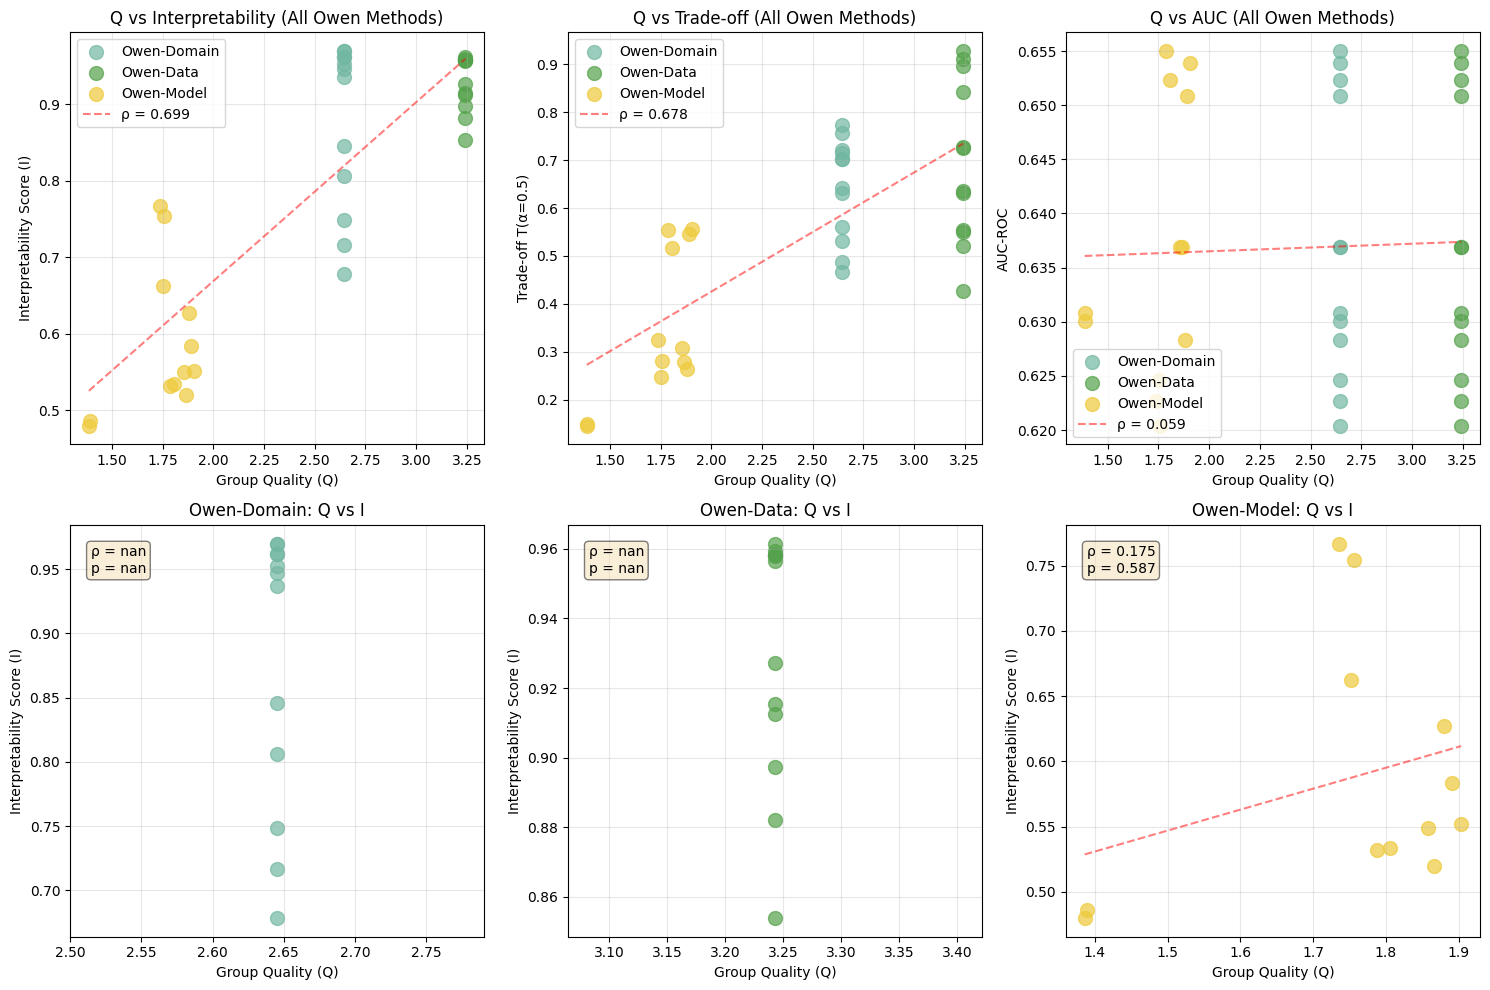

✓ Correlation plots saved as: q_correlation_analysis.png

5. LINEAR REGRESSION: Q AS PREDICTOR OF I

Owen-Domain:
  Regression: I = 0.4372 + 0.1653 * Q
  R² = -0.0000
  Interpretation: 0.1653 unit change in I per 1 unit change in Q

Owen-Data:
  Regression: I = 0.4642 + 0.1431 * Q
  R² = 0.0000
  Interpretation: 0.1431 unit change in I per 1 unit change in Q

Owen-Model:
  Regression: I = 0.3058 + 0.1607 * Q
  R² = 0.0886
  Interpretation: 0.1607 unit change in I per 1 unit change in Q

6. Q THRESHOLD ANALYSIS

Median Q = 2.645
High Q group (Q ≥ 2.645): 24 samples
Low Q group (Q < 2.645): 12 samples

I:
  High Q group mean: 0.9014
  Low Q group mean:  0.5872
  Difference:        0.3143 (+53.5%)

T(α=0.5):
  High Q group mean: 0.6683
  Low Q group mean:  0.3477
  Difference:        0.3206 (+92.2%)

AUC:
  High Q group mean: 0.6369
  Low Q group mean:  0.6369
  Difference:        0.0000 (+0.0%)

Q CORRELATION ANALYSIS COMPLETE


In [3]:
# ============================================================
# CORRELATION ANALYSIS: GROUP QUALITY (Q) vs INTERPRETABILITY
# ============================================================

import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("CORRELATION ANALYSIS: GROUP QUALITY (Q) vs INTERPRETABILITY METRICS")
print("="*80)

# Load your results
try:
    metrics = pd.read_csv('lc_generic_unified_results.csv')
    print("✓ Results loaded successfully")
    print(f"Dataset shape: {metrics.shape}")
    print(f"Methods with Q values: {metrics[metrics['Q'].notna()]['Method'].unique()}")
except FileNotFoundError:
    print("⚠ File not found. Please ensure 'lc_generic_unified_results.csv' exists.")
    # If metrics is already in memory
    if 'metrics' not in globals():
        raise ValueError("Please run the experiment first or ensure 'metrics' exists")
    else:
        print("✓ Using in-memory metrics")

# Filter only Owen methods (since only they have Q values)
owen_metrics = metrics[metrics['Method'].str.contains('Owen')].copy()
print(f"\nOwen methods data shape: {owen_metrics.shape}")

# Check if we have Q values
if owen_metrics['Q'].isna().all():
    print("⚠ No Q values found in the dataset")
else:
    # Remove rows with NaN Q values
    owen_metrics = owen_metrics.dropna(subset=['Q'])
    print(f"\nData with Q values: {owen_metrics.shape[0]} rows")

    # ============================================================
    # 1. OVERALL CORRELATIONS (All Owen methods combined)
    # ============================================================
    print("\n" + "="*80)
    print("1. OVERALL CORRELATIONS (All Owen Methods Combined)")
    print("="*80)

    # Prepare correlation matrix
    corr_matrix = owen_metrics[['Q', 'I', 'T(α=0.5)', 'AUC', 'Stability', 'Kuncheva', 'Cosine']].corr(method='spearman')

    print("\nSpearman Correlation Matrix:")
    print(corr_matrix.round(3))

    # Focus on Q correlations
    print("\n" + "="*60)
    print("FOCUS ON GROUP QUALITY (Q) CORRELATIONS:")
    print("="*60)

    for target in ['I', 'T(α=0.5)', 'AUC', 'Stability', 'Kuncheva', 'Cosine']:
        if target in owen_metrics.columns:
            rho, p_value = spearmanr(owen_metrics['Q'], owen_metrics[target])
            sig = "✓" if p_value < 0.05 else "✗"
            direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
            strength = "Strong" if abs(rho) >= 0.7 else "Moderate" if abs(rho) >= 0.3 else "Weak"
            print(f"  Q vs {target:15}: ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")

    # ============================================================
    # 2. BY METHOD CORRELATIONS
    # ============================================================
    print("\n" + "="*80)
    print("2. CORRELATIONS BY OWEN METHOD")
    print("="*80)

    owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']

    for method in owen_methods:
        method_data = owen_metrics[owen_metrics['Method'] == method]
        if len(method_data) >= 3 and method_data['Q'].notna().any():
            print(f"\n{method}:")
            print("-" * 40)

            # Q vs I
            if 'I' in method_data.columns and method_data['I'].notna().any():
                rho_I, p_I = spearmanr(method_data['Q'], method_data['I'])
                sig_I = "✓" if p_I < 0.05 else "✗"
                direction_I = "(+)" if rho_I > 0 else "(-)" if rho_I < 0 else "(0)"
                strength_I = "Strong" if abs(rho_I) >= 0.7 else "Moderate" if abs(rho_I) >= 0.3 else "Weak"
                print(f"  Q vs I:       ρ = {rho_I:.4f}, p = {p_I:.4f} {sig_I} {direction_I} {strength_I}")

            # Q vs T
            if 'T(α=0.5)' in method_data.columns and method_data['T(α=0.5)'].notna().any():
                rho_T, p_T = spearmanr(method_data['Q'], method_data['T(α=0.5)'])
                sig_T = "✓" if p_T < 0.05 else "✗"
                direction_T = "(+)" if rho_T > 0 else "(-)" if rho_T < 0 else "(0)"
                strength_T = "Strong" if abs(rho_T) >= 0.7 else "Moderate" if abs(rho_T) >= 0.3 else "Weak"
                print(f"  Q vs T(α=0.5): ρ = {rho_T:.4f}, p = {p_T:.4f} {sig_T} {direction_T} {strength_T}")

            # Q vs AUC
            if 'AUC' in method_data.columns and method_data['AUC'].notna().any():
                rho_A, p_A = spearmanr(method_data['Q'], method_data['AUC'])
                sig_A = "✓" if p_A < 0.05 else "✗"
                direction_A = "(+)" if rho_A > 0 else "(-)" if rho_A < 0 else "(0)"
                strength_A = "Strong" if abs(rho_A) >= 0.7 else "Moderate" if abs(rho_A) >= 0.3 else "Weak"
                print(f"  Q vs AUC:     ρ = {rho_A:.4f}, p = {p_A:.4f} {sig_A} {direction_A} {strength_A}")

    # ============================================================
    # 3. BY GROUPING STRATEGY
    # ============================================================
    print("\n" + "="*80)
    print("3. Q STATISTICS BY GROUPING STRATEGY")
    print("="*80)

    # Summary statistics of Q for each Owen method
    q_stats = owen_metrics.groupby('Method')['Q'].agg(['mean', 'std', 'min', 'max', 'count']).round(4)
    print("\nGroup Quality (Q) Statistics:")
    print(q_stats)

    # ============================================================
    # 4. VISUALIZATIONS
    # ============================================================
    print("\n" + "="*80)
    print("4. VISUALIZING Q CORRELATIONS")
    print("="*80)

    # Set up colors for Owen methods
    colors = {
        'Owen-Domain': '#72B7A2',
        'Owen-Data': '#54A24B',
        'Owen-Model': '#EECA3B'
    }

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot 1: Q vs I (all methods)
    ax1 = axes[0]
    for method in owen_methods:
        method_data = owen_metrics[owen_metrics['Method'] == method]
        if len(method_data) > 0:
            ax1.scatter(method_data['Q'], method_data['I'],
                       color=colors.get(method, 'gray'),
                       label=method, alpha=0.7, s=100)

    # Add regression line
    if len(owen_metrics) > 1:
        z = np.polyfit(owen_metrics['Q'], owen_metrics['I'], 1)
        p = np.poly1d(z)
        ax1.plot(sorted(owen_metrics['Q']), p(sorted(owen_metrics['Q'])),
                "r--", alpha=0.5, label=f"ρ = {spearmanr(owen_metrics['Q'], owen_metrics['I'])[0]:.3f}")

    ax1.set_xlabel('Group Quality (Q)')
    ax1.set_ylabel('Interpretability Score (I)')
    ax1.set_title('Q vs Interpretability (All Owen Methods)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Q vs T (all methods)
    ax2 = axes[1]
    for method in owen_methods:
        method_data = owen_metrics[owen_metrics['Method'] == method]
        if len(method_data) > 0:
            ax2.scatter(method_data['Q'], method_data['T(α=0.5)'],
                       color=colors.get(method, 'gray'),
                       label=method, alpha=0.7, s=100)

    if len(owen_metrics) > 1:
        z = np.polyfit(owen_metrics['Q'], owen_metrics['T(α=0.5)'], 1)
        p = np.poly1d(z)
        ax2.plot(sorted(owen_metrics['Q']), p(sorted(owen_metrics['Q'])),
                "r--", alpha=0.5, label=f"ρ = {spearmanr(owen_metrics['Q'], owen_metrics['T(α=0.5)'])[0]:.3f}")

    ax2.set_xlabel('Group Quality (Q)')
    ax2.set_ylabel('Trade-off T(α=0.5)')
    ax2.set_title('Q vs Trade-off (All Owen Methods)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Q vs AUC (all methods)
    ax3 = axes[2]
    for method in owen_methods:
        method_data = owen_metrics[owen_metrics['Method'] == method]
        if len(method_data) > 0:
            ax3.scatter(method_data['Q'], method_data['AUC'],
                       color=colors.get(method, 'gray'),
                       label=method, alpha=0.7, s=100)

    if len(owen_metrics) > 1:
        z = np.polyfit(owen_metrics['Q'], owen_metrics['AUC'], 1)
        p = np.poly1d(z)
        ax3.plot(sorted(owen_metrics['Q']), p(sorted(owen_metrics['Q'])),
                "r--", alpha=0.5, label=f"ρ = {spearmanr(owen_metrics['Q'], owen_metrics['AUC'])[0]:.3f}")

    ax3.set_xlabel('Group Quality (Q)')
    ax3.set_ylabel('AUC-ROC')
    ax3.set_title('Q vs AUC (All Owen Methods)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4-6: Individual methods Q vs I
    for idx, method in enumerate(owen_methods):
        if idx < 3:  # Ensure we don't exceed axes
            ax = axes[idx + 3]
            method_data = owen_metrics[owen_metrics['Method'] == method]

            if len(method_data) > 1:
                ax.scatter(method_data['Q'], method_data['I'],
                          color=colors.get(method, 'gray'),
                          alpha=0.7, s=100)

                # Add regression line
                z = np.polyfit(method_data['Q'], method_data['I'], 1)
                p = np.poly1d(z)
                ax.plot(sorted(method_data['Q']), p(sorted(method_data['Q'])),
                       "r--", alpha=0.5)

                rho, p_val = spearmanr(method_data['Q'], method_data['I'])
                ax.text(0.05, 0.95, f"ρ = {rho:.3f}\np = {p_val:.3f}",
                       transform=ax.transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

                ax.set_xlabel('Group Quality (Q)')
                ax.set_ylabel('Interpretability Score (I)')
                ax.set_title(f'{method}: Q vs I')
                ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('q_correlation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Correlation plots saved as: q_correlation_analysis.png")

    # ============================================================
    # 5. REGRESSION ANALYSIS
    # ============================================================
    print("\n" + "="*80)
    print("5. LINEAR REGRESSION: Q AS PREDICTOR OF I")
    print("="*80)

    # Simple linear regression for each Owen method
    for method in owen_methods:
        method_data = owen_metrics[owen_metrics['Method'] == method]
        if len(method_data) > 1:
            # Remove any NaN values
            clean_data = method_data[['Q', 'I']].dropna()
            if len(clean_data) >= 3:
                x = clean_data['Q'].values
                y = clean_data['I'].values

                # Linear regression
                slope, intercept = np.polyfit(x, y, 1)
                y_pred = slope * x + intercept

                # R-squared
                ss_res = np.sum((y - y_pred) ** 2)
                ss_tot = np.sum((y - np.mean(y)) ** 2)
                r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

                print(f"\n{method}:")
                print(f"  Regression: I = {intercept:.4f} + {slope:.4f} * Q")
                print(f"  R² = {r_squared:.4f}")
                print(f"  Interpretation: {slope:.4f} unit change in I per 1 unit change in Q")

    # ============================================================
    # 6. Q THRESHOLD ANALYSIS
    # ============================================================
    print("\n" + "="*80)
    print("6. Q THRESHOLD ANALYSIS")
    print("="*80)

    if len(owen_metrics) > 0:
        # Find median Q
        median_q = owen_metrics['Q'].median()

        # Split into high and low Q groups
        high_q = owen_metrics[owen_metrics['Q'] >= median_q]
        low_q = owen_metrics[owen_metrics['Q'] < median_q]

        print(f"\nMedian Q = {median_q:.3f}")
        print(f"High Q group (Q ≥ {median_q:.3f}): {len(high_q)} samples")
        print(f"Low Q group (Q < {median_q:.3f}): {len(low_q)} samples")

        # Compare I and T between groups
        for metric in ['I', 'T(α=0.5)', 'AUC']:
            if metric in owen_metrics.columns:
                high_mean = high_q[metric].mean()
                low_mean = low_q[metric].mean()
                diff = high_mean - low_mean
                percent_diff = (diff / low_mean * 100) if low_mean != 0 else 0

                print(f"\n{metric}:")
                print(f"  High Q group mean: {high_mean:.4f}")
                print(f"  Low Q group mean:  {low_mean:.4f}")
                print(f"  Difference:        {diff:.4f} ({percent_diff:+.1f}%)")

print("\n" + "="*80)
print("Q CORRELATION ANALYSIS COMPLETE")
print("="*80)

In [ ]:
#FIXED FRIEDMAN + NEMENYI (T metric)

In [6]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

print("\nFriedman + Nemenyi Test for T(α=0.5) [FIXED]")

pivot_T = metrics.pivot(
    index=['Model', 'Sampler'],
    columns='Method',
    values='T(α=0.5)'
)

# Keep only rows with ALL methods present
pivot_T_clean = pivot_T.dropna(axis=0, how='any')

methods_used = [m for m in method_order if m in pivot_T_clean.columns]

print(f"Balanced blocks: {pivot_T_clean.shape[0]}")
print(f"Methods used: {methods_used}")

if pivot_T_clean.shape[0] >= 3 and len(methods_used) >= 3:
    data = pivot_T_clean[methods_used].values

    # Friedman
    stat, p = friedmanchisquare(*[data[:, i] for i in range(data.shape[1])])
    print(f"Friedman χ² = {stat:.4f}, p = {p:.6f}")

    if p < 0.05:
        print("✓ Significant differences → running Nemenyi")

        nemenyi = sp.posthoc_nemenyi_friedman(data)
        nemenyi_df = pd.DataFrame(
            nemenyi,
            index=methods_used,
            columns=methods_used
        )

        print("\nNemenyi post-hoc p-values:")
        print(nemenyi_df.round(4))
    else:
        print("✗ No significant differences")
else:
    print("Insufficient balanced data for Nemenyi test")



Friedman + Nemenyi Test for T(α=0.5) [FIXED]
Balanced blocks: 12
Methods used: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
Friedman χ² = 40.6667, p = 0.000000
✓ Significant differences → running Nemenyi

Nemenyi post-hoc p-values:
             SHAP  Banzhaf  Myerson  Owen-Domain  Owen-Data  Owen-Model
SHAP          NaN      NaN      NaN          NaN        NaN         NaN
Banzhaf       NaN      NaN      NaN          NaN        NaN         NaN
Myerson       NaN      NaN      NaN          NaN        NaN         NaN
Owen-Domain   NaN      NaN      NaN          NaN        NaN         NaN
Owen-Data     NaN      NaN      NaN          NaN        NaN         NaN
Owen-Model    NaN      NaN      NaN          NaN        NaN         NaN


SAME FIX FOR INTERPRETABILITY I

In [7]:
print("\nFriedman + Nemenyi Test for Interpretability I [FIXED]")

pivot_I = metrics.pivot(
    index=['Model', 'Sampler'],
    columns='Method',
    values='I'
)

pivot_I_clean = pivot_I.dropna(axis=0, how='any')
methods_used = [m for m in method_order if m in pivot_I_clean.columns]

print(f"Balanced blocks: {pivot_I_clean.shape[0]}")
print(f"Methods used: {methods_used}")

if pivot_I_clean.shape[0] >= 3 and len(methods_used) >= 3:
    data = pivot_I_clean[methods_used].values

    stat, p = friedmanchisquare(*[data[:, i] for i in range(data.shape[1])])
    print(f"Friedman χ² = {stat:.4f}, p = {p:.6f}")

    if p < 0.05:
        nemenyi = sp.posthoc_nemenyi_friedman(data)
        nemenyi_df = pd.DataFrame(
            nemenyi,
            index=methods_used,
            columns=methods_used
        )
        print("\nNemenyi post-hoc p-values:")
        print(nemenyi_df.round(4))
else:
    print("Insufficient balanced data for Nemenyi test")



Friedman + Nemenyi Test for Interpretability I [FIXED]
Balanced blocks: 12
Methods used: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
Friedman χ² = 40.6667, p = 0.000000

Nemenyi post-hoc p-values:
             SHAP  Banzhaf  Myerson  Owen-Domain  Owen-Data  Owen-Model
SHAP          NaN      NaN      NaN          NaN        NaN         NaN
Banzhaf       NaN      NaN      NaN          NaN        NaN         NaN
Myerson       NaN      NaN      NaN          NaN        NaN         NaN
Owen-Domain   NaN      NaN      NaN          NaN        NaN         NaN
Owen-Data     NaN      NaN      NaN          NaN        NaN         NaN
Owen-Model    NaN      NaN      NaN          NaN        NaN         NaN


In [4]:
# SIMPLER FRIEDMAN TEST (more robust)
print("\nSimplified Friedman Test (using mean values):")

# Use mean values per method instead of raw data
method_means_T = metrics.groupby('Method')['T(α=0.5)'].mean()
method_means_I = metrics.groupby('Method')['I'].mean()

print("\nMean T(α=0.5) by method:")
for method, value in method_means_T.items():
    print(f"  {method:15}: {value:.4f}")

print("\nMean I by method:")
for method, value in method_means_I.items():
    print(f"  {method:15}: {value:.4f}")

# Statistical test on means (t-test or Mann-Whitney)
print("\nPairwise comparisons (Mann-Whitney U test):")
methods = method_means_T.index.tolist()

for i in range(len(methods)):
    for j in range(i+1, len(methods)):
        method1, method2 = methods[i], methods[j]
        data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
        data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

        if len(data1) > 1 and len(data2) > 1:
            try:
                u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                sig = "✓" if p_val < 0.05 else "✗"
                mean1, mean2 = np.mean(data1), np.mean(data2)
                print(f"  {method1:15} vs {method2:15}: p = {p_val:.4f} {sig} (means: {mean1:.3f} vs {mean2:.3f})")
            except:
                pass


Simplified Friedman Test (using mean values):

Mean T(α=0.5) by method:
  Banzhaf        : 0.4562
  Myerson        : 0.4568
  Owen-Data      : 0.6958
  Owen-Domain    : 0.6408
  Owen-Model     : 0.3477
  SHAP           : 0.5121

Mean I by method:
  Banzhaf        : 0.6936
  Myerson        : 0.6941
  Owen-Data      : 0.9284
  Owen-Domain    : 0.8745
  Owen-Model     : 0.5872
  SHAP           : 0.7483

Pairwise comparisons (Mann-Whitney U test):
  Banzhaf         vs Myerson        : p = 0.9770 ✗ (means: 0.456 vs 0.457)
  Banzhaf         vs Owen-Data      : p = 0.0086 ✓ (means: 0.456 vs 0.696)
  Banzhaf         vs Owen-Domain    : p = 0.0061 ✓ (means: 0.456 vs 0.641)
  Banzhaf         vs Owen-Model     : p = 0.1410 ✗ (means: 0.456 vs 0.348)
  Banzhaf         vs SHAP           : p = 0.6236 ✗ (means: 0.456 vs 0.512)
  Myerson         vs Owen-Data      : p = 0.0024 ✓ (means: 0.457 vs 0.696)
  Myerson         vs Owen-Domain    : p = 0.0020 ✓ (means: 0.457 vs 0.641)
  Myerson         vs Owen-

In [8]:
# ============================================================
# 5. FRIEDMAN & NEMENYI TESTS (PROPERLY FIXED)
# ============================================================
print("\n" + "="*80)
print("5. FRIEDMAN & NEMENYI TESTS")
print("="*80)

def prepare_friedman_data(metrics_df, metric_name):
    """
    Prepare data for Friedman test by filling missing values appropriately
    """
    # Create pivot table
    pivot_df = metrics_df.pivot_table(
        values=metric_name,
        index=['Model', 'Sampler'],
        columns='Method'
    )

    # Get methods that exist in the data
    available_methods = [m for m in method_order if m in pivot_df.columns]

    # Select only available methods
    pivot_df = pivot_df[available_methods]

    # Check if we have enough data
    if len(pivot_df) < 3:
        print(f"⚠ Insufficient configurations for {metric_name}: only {len(pivot_df)} available")
        return None, None

    # Count missing values per method
    missing_info = {}
    for method in available_methods:
        missing_count = pivot_df[method].isna().sum()
        total = len(pivot_df)
        missing_info[method] = (missing_count, total, missing_count/total*100)

    print(f"\nMissing data analysis for {metric_name}:")
    for method, (missing, total, pct) in missing_info.items():
        print(f"  {method:15}: {missing}/{total} missing ({pct:.1f}%)")

    # Strategy 1: Remove rows with any missing values (complete case analysis)
    complete_cases = pivot_df.dropna()
    if len(complete_cases) >= 3:
        print(f"✓ Complete cases: {len(complete_cases)} configurations")
        return complete_cases.values, available_methods

    # Strategy 2: Fill missing with column median
    print(f"⚠ Only {len(complete_cases)} complete cases, filling missing values...")
    filled_df = pivot_df.copy()
    for method in available_methods:
        if filled_df[method].isna().any():
            col_median = filled_df[method].median()
            filled_df[method] = filled_df[method].fillna(col_median)
            print(f"  Filled {method} with median: {col_median:.4f}")

    return filled_df.values, available_methods

# ============================================================
# FRIEDMAN & NEMENYI FOR T(α=0.5)
# ============================================================
print("\n" + "="*60)
print("Friedman Test for T(α=0.5)")
print("="*60)

data_matrix_T, methods_T = prepare_friedman_data(metrics, 'T(α=0.5)')

if data_matrix_T is not None and len(methods_T) >= 3:
    print(f"\nMethods included: {methods_T}")
    print(f"Data matrix shape: {data_matrix_T.shape}")

    # Perform Friedman test
    try:
        stat_T, p_T = friedmanchisquare(*[data_matrix_T[:, i] for i in range(data_matrix_T.shape[1])])
        print(f"\nFriedman Test Results:")
        print(f"χ² = {stat_T:.4f}, p = {p_T:.6f}")

        if p_T < 0.05:
            print("✓ SIGNIFICANT differences between methods (p < 0.05)")

            # Perform Nemenyi post-hoc test
            print("\n" + "-"*60)
            print("Nemenyi Post-Hoc Test (p-values):")
            print("-"*60)

            try:
                nemenyi_matrix = sp.posthoc_nemenyi_friedman(data_matrix_T)

                # Convert to readable DataFrame
                nemenyi_df = pd.DataFrame(
                    nemenyi_matrix,
                    index=methods_T,
                    columns=methods_T
                ).round(4)

                # Display the matrix
                print("\nFull p-value matrix:")
                print(nemenyi_df.to_string())

                # Extract and display significant pairs
                print("\n" + "-"*60)
                print("Significant Differences (p < 0.05):")
                print("-"*60)

                significant_pairs = []
                for i in range(len(methods_T)):
                    for j in range(i+1, len(methods_T)):
                        p_val = nemenyi_df.iloc[i, j]
                        if p_val < 0.05:
                            method1 = methods_T[i]
                            method2 = methods_T[j]
                            significant_pairs.append((method1, method2, p_val))

                if significant_pairs:
                    for method1, method2, p_val in significant_pairs:
                        # Get means for context
                        mean1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].mean()
                        mean2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].mean()
                        direction = ">" if mean1 > mean2 else "<"
                        print(f"  {method1:15} {direction} {method2:15}: p = {p_val:.4f} (means: {mean1:.3f} vs {mean2:.3f})")
                else:
                    print("  No significant pairwise differences found (all p ≥ 0.05)")

                # Create a simplified significance matrix
                print("\n" + "-"*60)
                print("Significance Matrix (★ = p < 0.05):")
                print("-"*60)

                # Header
                header = "Method          " + " ".join([f"{m:>10}" for m in methods_T])
                print(header)
                print("-" * len(header))

                for i, method1 in enumerate(methods_T):
                    row = f"{method1:15}"
                    for j, method2 in enumerate(methods_T):
                        if i == j:
                            row += " " * 11
                        else:
                            p_val = nemenyi_df.iloc[i, j]
                            row += f"{'★':>10}" if p_val < 0.05 else f"{' ':>10}"
                    print(row)

            except Exception as e:
                print(f"⚠ Nemenyi test failed: {e}")
                print("  Falling back to Wilcoxon signed-rank tests...")

                # Wilcoxon fallback
                print("\nPairwise Wilcoxon Signed-Rank Tests:")
                for i in range(len(methods_T)):
                    for j in range(i+1, len(methods_T)):
                        method1, method2 = methods_T[i], methods_T[j]

                        # Get aligned data
                        subset = metrics[metrics['Method'].isin([method1, method2])]
                        pivot_sub = subset.pivot_table(
                            values='T(α=0.5)',
                            index=['Model', 'Sampler'],
                            columns='Method'
                        ).dropna()

                        if len(pivot_sub) >= 3:
                            data1 = pivot_sub[method1].values
                            data2 = pivot_sub[method2].values

                            try:
                                w_stat, w_p = wilcoxon(data1, data2)
                                sig = "✓" if w_p < 0.05 else "✗"
                                mean1, mean2 = np.mean(data1), np.mean(data2)
                                print(f"  {method1:15} vs {method2:15}: p = {w_p:.4f} {sig} (means: {mean1:.3f} vs {mean2:.3f})")
                            except:
                                pass
        else:
            print("✗ No significant differences between methods (p ≥ 0.05)")

    except Exception as e:
        print(f"⚠ Friedman test failed: {e}")

# ============================================================
# FRIEDMAN & NEMENYI FOR INTERPRETABILITY (I)
# ============================================================
print("\n" + "="*60)
print("Friedman Test for Interpretability (I)")
print("="*60)

data_matrix_I, methods_I = prepare_friedman_data(metrics, 'I')

if data_matrix_I is not None and len(methods_I) >= 3:
    print(f"\nMethods included: {methods_I}")
    print(f"Data matrix shape: {data_matrix_I.shape}")

    # Perform Friedman test
    try:
        stat_I, p_I = friedmanchisquare(*[data_matrix_I[:, i] for i in range(data_matrix_I.shape[1])])
        print(f"\nFriedman Test Results:")
        print(f"χ² = {stat_I:.4f}, p = {p_I:.6f}")

        if p_I < 0.05:
            print("✓ SIGNIFICANT differences between methods (p < 0.05)")

            # Perform Nemenyi post-hoc test
            print("\n" + "-"*60)
            print("Nemenyi Post-Hoc Test (p-values):")
            print("-"*60)

            try:
                nemenyi_matrix = sp.posthoc_nemenyi_friedman(data_matrix_I)

                # Convert to readable DataFrame
                nemenyi_df = pd.DataFrame(
                    nemenyi_matrix,
                    index=methods_I,
                    columns=methods_I
                ).round(4)

                # Display the matrix
                print("\nFull p-value matrix:")
                print(nemenyi_df.to_string())

                # Extract and display significant pairs
                print("\n" + "-"*60)
                print("Significant Differences (p < 0.05):")
                print("-"*60)

                significant_pairs = []
                for i in range(len(methods_I)):
                    for j in range(i+1, len(methods_I)):
                        p_val = nemenyi_df.iloc[i, j]
                        if p_val < 0.05:
                            method1 = methods_I[i]
                            method2 = methods_I[j]
                            significant_pairs.append((method1, method2, p_val))

                if significant_pairs:
                    for method1, method2, p_val in significant_pairs:
                        # Get means for context
                        mean1 = metrics[metrics['Method'] == method1]['I'].mean()
                        mean2 = metrics[metrics['Method'] == method2]['I'].mean()
                        direction = ">" if mean1 > mean2 else "<"
                        print(f"  {method1:15} {direction} {method2:15}: p = {p_val:.4f} (means: {mean1:.3f} vs {mean2:.3f})")
                else:
                    print("  No significant pairwise differences found (all p ≥ 0.05)")

                # Create a simplified significance matrix
                print("\n" + "-"*60)
                print("Significance Matrix (★ = p < 0.05):")
                print("-"*60)

                # Header
                header = "Method          " + " ".join([f"{m:>10}" for m in methods_I])
                print(header)
                print("-" * len(header))

                for i, method1 in enumerate(methods_I):
                    row = f"{method1:15}"
                    for j, method2 in enumerate(methods_I):
                        if i == j:
                            row += " " * 11
                        else:
                            p_val = nemenyi_df.iloc[i, j]
                            row += f"{'★':>10}" if p_val < 0.05 else f"{' ':>10}"
                    print(row)

            except Exception as e:
                print(f"⚠ Nemenyi test failed: {e}")
                print("  Falling back to Wilcoxon signed-rank tests...")

                # Wilcoxon fallback
                print("\nPairwise Wilcoxon Signed-Rank Tests:")
                for i in range(len(methods_I)):
                    for j in range(i+1, len(methods_I)):
                        method1, method2 = methods_I[i], methods_I[j]

                        # Get aligned data
                        subset = metrics[metrics['Method'].isin([method1, method2])]
                        pivot_sub = subset.pivot_table(
                            values='I',
                            index=['Model', 'Sampler'],
                            columns='Method'
                        ).dropna()

                        if len(pivot_sub) >= 3:
                            data1 = pivot_sub[method1].values
                            data2 = pivot_sub[method2].values

                            try:
                                w_stat, w_p = wilcoxon(data1, data2)
                                sig = "✓" if w_p < 0.05 else "✗"
                                mean1, mean2 = np.mean(data1), np.mean(data2)
                                print(f"  {method1:15} vs {method2:15}: p = {w_p:.4f} {sig} (means: {mean1:.3f} vs {mean2:.3f})")
                            except:
                                pass
        else:
            print("✗ No significant differences between methods (p ≥ 0.05)")

    except Exception as e:
        print(f"⚠ Friedman test failed: {e}")


5. FRIEDMAN & NEMENYI TESTS

Friedman Test for T(α=0.5)

Missing data analysis for T(α=0.5):
  SHAP           : 0/9 missing (0.0%)
  Banzhaf        : 0/9 missing (0.0%)
  Myerson        : 0/9 missing (0.0%)
  Owen-Domain    : 0/9 missing (0.0%)
  Owen-Data      : 0/9 missing (0.0%)
  Owen-Model     : 0/9 missing (0.0%)
✓ Complete cases: 9 configurations

Methods included: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
Data matrix shape: (9, 6)

Friedman Test Results:
χ² = 32.7460, p = 0.000004
✓ SIGNIFICANT differences between methods (p < 0.05)

------------------------------------------------------------
Nemenyi Post-Hoc Test (p-values):
------------------------------------------------------------

Full p-value matrix:
             SHAP  Banzhaf  Myerson  Owen-Domain  Owen-Data  Owen-Model
SHAP          NaN      NaN      NaN          NaN        NaN         NaN
Banzhaf       NaN      NaN      NaN          NaN        NaN         NaN
Myerson       NaN      NaN

In [9]:
import pandas as pd

ranks = pd.DataFrame(
    data_matrix_T,
    columns=methods_T
).rank(axis=1)

print("\nAverage ranks:")
print(ranks.mean().sort_values())

print("\nRank variance per method:")
print(ranks.var())



Average ranks:
Owen-Model     1.555556
Banzhaf        2.666667
SHAP           2.777778
Myerson        3.111111
Owen-Domain    5.333333
Owen-Data      5.555556
dtype: float64

Rank variance per method:
SHAP           1.444444
Banzhaf        1.000000
Myerson        0.861111
Owen-Domain    0.500000
Owen-Data      0.277778
Owen-Model     1.277778
dtype: float64
